# Project milestone 3 : NeverEnoughData team

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import os
from sklearn.cluster import KMeans
import seaborn as sns
from yellowbrick.cluster import KElbowVisualizer
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from scipy.stats import kstest, skewtest
import statsmodels.formula.api as smf
import statsmodels.api as sm
import networkx as nx

path = 'drive/MyDrive/ADA_Dataset'
do_transform = False

## Data transformation

**Important** : As this part concerns data conversion from csv/txt to parquet it needs to be run only once. If the parquet files are already created please go directly to section *Data loading*

In order to load more efficently the data let's first convert every part of the RateBeer dataset in the parquet format.

To do so let's begin by loading all the csv files and then convert them into parquet.

In [ ]:
if do_transform:
  df_beers = pd.read_csv(path+'/RateBeer/beers.csv')
  df_breweries = pd.read_csv(path+'/RateBeer/breweries.csv')
  df_users = pd.read_csv(path+'/RateBeer/users.csv')

In [ ]:
if do_transform:
  df_beers.to_parquet(path+'/RateBeer/beers.parquet.snappy')
  df_breweries.to_parquet(path+'/RateBeer/breweries.parquet.snappy')
  df_users.to_parquet(path+'/RateBeer/users.parquet.snappy')

In [ ]:
if do_transform:
  del df_beers
  del df_breweries
  del df_users

We can show that the data size has signifanctly decrease.

In [ ]:
beers_csv_s = os.path.getsize(path+'/RateBeer/beers.csv')/1000000
beers_par_s = os.path.getsize(path+'/RateBeer/beers.parquet.snappy')/1000000

breweries_csv_s = os.path.getsize(path+'/RateBeer/breweries.csv')/1000000
breweries_par_s = os.path.getsize(path+'/RateBeer/breweries.parquet.snappy')/1000000

users_csv_s = os.path.getsize(path+'/RateBeer/users.csv')/1000000
users_par_s = os.path.getsize(path+'/RateBeer/users.parquet.snappy')/1000000

print(f'Beers file size before : {beers_csv_s:.2f} MB')
print(f'Beers file size after : {beers_par_s:.2f} MB')

print(f'Breweries file size before : {breweries_csv_s:.2f} MB')
print(f'Breweries file size after : {breweries_par_s:.2f} MB')

print(f'Users file size before : {users_csv_s:.2f} MB')
print(f'Users file size after : {users_par_s:.2f} MB')


Beers file size before : 47.20 MB
Beers file size after : 13.45 MB
Breweries file size before : 1.04 MB
Breweries file size after : 0.57 MB
Users file size before : 3.20 MB
Users file size after : 1.69 MB


To finish the data conversion we can load the data from ratings.txt into a dataframe.

As seen in the part 2 of the project, this file has another format and requires more work to put it into a dataframe. This methods require quite some time and the loading from a parquet for the nexts steps will be way faster than from this file.

In this case as some data are already present in other parts of the dataset (like the Beer Name that can be found via the beer_id) we will only keep the data that are not present elsewhere or needed to make the link between the different files. This will also help to reduce the size of the data.

In [ ]:
if do_transform:

  df_ratings = pd.DataFrame()

  cols_to_keep = {
      'beer_id' : int, 'brewery_id' : int, 'date' : int, 'user_id' : int, 'appearance' : int,
      'aroma' : int, 'palate' : int, 'taste' : int, 'overall' : int, 'rating' : float, 'text' : str
  }

  start_elt_marker = 'beer_name'
  end_elt_marker = 'text'

  with open(path+'/RateBeer/ratings.txt/ratings.txt', "r") as f:
    line = f.readline()
    count = 0
    prepa_data = {}
    while line != '':
      #line = f.readline()

      line_spl = line.split(': ')
      if line_spl[0] == start_elt_marker:
        count += 1

      if line_spl[0] in cols_to_keep and len(line_spl) > 1:
        if line_spl[0] in prepa_data:
          prepa_data[line_spl[0]].append(cols_to_keep[line_spl[0]](': '.join(line_spl[1:])))
        else:
          prepa_data[line_spl[0]] = []
          prepa_data[line_spl[0]].append(cols_to_keep[line_spl[0]](': '.join(line_spl[1:])))

      if count >= 1000 and line_spl[0] == end_elt_marker:
        item_c = len(prepa_data['beer_id'])
        for col_to_keep in cols_to_keep:
          if item_c != len(prepa_data[col_to_keep]):
            raise

        new_df = pd.DataFrame(prepa_data)
        df_ratings = pd.concat([df_ratings, new_df])

        del prepa_data
        prepa_data = {}
        count = 0

      line = f.readline()

    new_df = pd.DataFrame(prepa_data)
    df_ratings = pd.concat([df_ratings, new_df])



In [ ]:
if do_transform:
  df_ratings.to_parquet(path+'/RateBeer/ratings.parquet.snappy')

In [ ]:
if do_transform:
  del df_ratings

We can see here the size difference between the 2 files (considering that this number is way smaller after also because we keep less data).

In [ ]:
ratings_csv_s = os.path.getsize(path+'/RateBeer/ratings.txt/ratings.txt')/1000000
ratings_par_s = os.path.getsize(path+'/RateBeer/ratings.parquet.snappy')/1000000

print(f'Ratings file size before : {ratings_csv_s:.2f} MB')
print(f'Ratings file size after : {ratings_par_s:.2f} MB')

Ratings file size before : 3947.75 MB
Ratings file size after : 1226.12 MB


## Data loading

To begin this exercice let's first load the dataset from our freshly made new parquet dataset :

In [ ]:
df_beers = pd.read_parquet(path+'/RateBeer/beers.parquet.snappy')
df_breweries = pd.read_parquet(path+'/RateBeer/breweries.parquet.snappy')
df_users = pd.read_parquet(path+'/RateBeer/users.parquet.snappy')
df_ratings = pd.read_parquet(path+'/RateBeer/ratings.parquet.snappy')

## Research question 1

**Questions \:**
How does beer preferences evolve? How does different beer styles become more popular by the time? Do they experience a decay in their popularity as time goes?


To begin let's recall how much different beer kinds are in our dataset

In [ ]:
beer_style_u = len(df_beers['style'].unique())
print(f'Total amount of beers style : {beer_style_u}')

print('Here are the 10 first elements')
display(df_beers['style'].unique().tolist()[0:10])

Total amount of beers style : 94
Here are the 10 first elements


['Pale Lager',
 'Stout',
 'Golden Ale/Blond Ale',
 'Bitter',
 'American Pale Ale',
 'Irish Ale',
 'Wheat Ale',
 'English Strong Ale',
 'Black IPA',
 'India Pale Ale (IPA)']

### Approach 1 : Automatic clustering

To have a better approach on beers the actual ratings trends among those beers, one good option would be first try to group these beers together based on their properties. We can do this via KMeans clustering. In  order to have a cluster that makes more sense (i.e. have a beer be only in one cluster) we first group the criteria by the beer_id in order to have only one entry per beer.

In [ ]:
ratings_reduced = df_ratings[['beer_id', 'appearance', 'aroma', 'palate', 'taste']].groupby('beer_id').mean()

ratings_r_avg_idx = ratings_reduced.index.to_numpy()
ratings_r_avg_data = ratings_reduced.to_numpy()

print('Shape of the beer ids and beer averaged data :')
print(ratings_r_avg_idx.shape)
print(ratings_r_avg_data.shape)

Shape of the beer ids and beer averaged data :
(396690,)
(396690, 4)


First to make it a bit more readable, we can do few functions that will return how much each style is likely to be part of a particular cluster

In [ ]:
def cluster_heatmap(beers_ids, k_labels):

  #step 1 : create df

  df_clusters = pd.get_dummies(pd.DataFrame({'k_label' : k_labels})['k_label'], prefix='C_')
  df_clusters['beer_id'] = beers_ids
  #step 2 : join style
  df_cluster_merged = pd.merge(df_clusters, df_beers[['beer_id','style']], on='beer_id', how='inner')

  #step 3 : group by and average
  df_cluster_merged = df_cluster_merged.drop(['beer_id'], axis=1)
  df_cluster_merged = df_cluster_merged.groupby('style').mean()

  #step 4 : heatmap
  display(df_cluster_merged)
  sns.heatmap(df_cluster_merged.sample(15))

  return df_cluster_merged


def elbow_method(x_data, from_i, to_i):
  model = KMeans(n_init='auto', random_state=0)
  visualizer = KElbowVisualizer(model, k=(from_i,to_i))
  visualizer.fit(x_data)
  visualizer.show()


def get_style_groups(cluster_merged):
  groups = {}
  group_nb = np.argmax(cluster_merged.to_numpy(), axis=1)

  for i in np.unique(group_nb).tolist():
    groups[i] = cluster_merged.index[group_nb == i].tolist()

  return groups


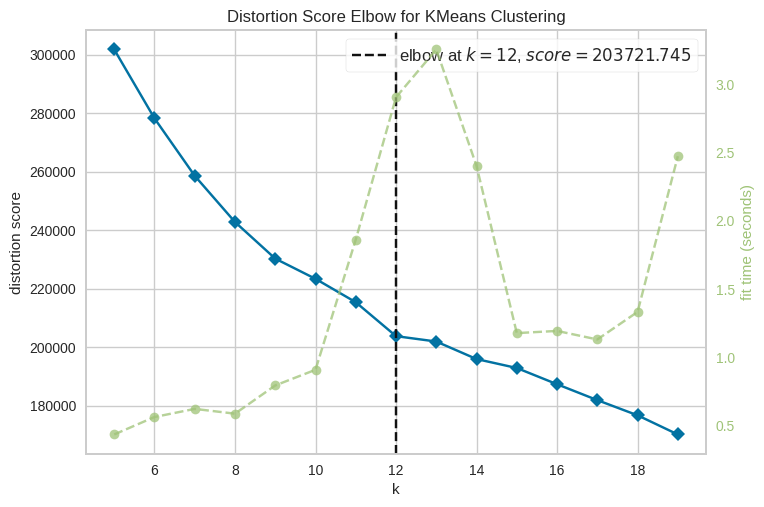

In [ ]:
elbow_method(ratings_r_avg_data, 5, 20)

,C__0,C__1,C__2,C__3,C__4,C__5,C__6,C__7,C__8,C__9
style,,,,,,,,,,
Abbey Dubbel,0.145624,0.021601,0.038734,0.172067,0.200745,0.021229,0.005214,0.050652,0.286034,0.058101
Abbey Tripel,0.185529,0.015203,0.029842,0.181869,0.174550,0.016892,0.004786,0.064752,0.280968,0.045608
Abt/Quadrupel,0.177419,0.013324,0.024544,0.322581,0.082749,0.004208,0.001403,0.198457,0.157083,0.018233
Altbier,0.103120,0.029614,0.075621,0.126388,0.240085,0.028027,0.010048,0.020624,0.256478,0.109995
Amber Ale,0.092922,0.033952,0.060856,0.107515,0.256031,0.047056,0.011714,0.022535,0.233098,0.134319
...,...,...,...,...,...,...,...,...,...,...
Traditional Ale,0.125070,0.020845,0.037183,0.104789,0.242254,0.061972,0.011268,0.036620,0.210704,0.149296
Weizen Bock,0.174153,0.017277,0.030408,0.212163,0.149965,0.015204,0.004838,0.059433,0.282654,0.053905
Wheat Ale,0.120474,0.028356,0.046299,0.099968,0.235181,0.056392,0.015219,0.036046,0.192887,0.169177


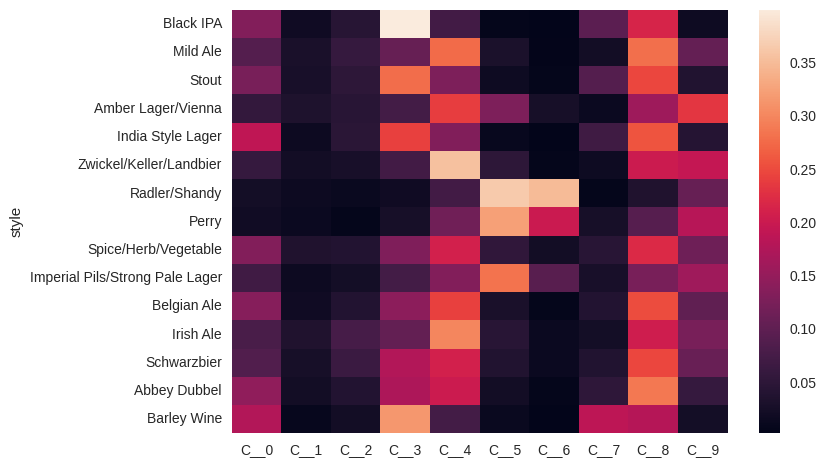

In [ ]:
kmeans = KMeans(n_init='auto', n_clusters=10, random_state=0).fit(ratings_r_avg_data)

df_cluster_merged = cluster_heatmap(ratings_r_avg_idx, kmeans.labels_)

We can also see the differences betwwen those groups by showing the cluster centers.

In [ ]:
criterias = ['appearance', 'aroma', 'palate', 'taste']

df_cluster_centers = pd.DataFrame({cr:kmeans.cluster_centers_[:, idx] for idx, cr in enumerate(criterias)})
display(df_cluster_centers)

,appearance,aroma,palate,taste
0,3.165504,7.098649,3.246220,7.078279
1,3.817496,5.579370,3.031562,4.819015
2,4.076788,5.888960,3.913205,6.469752
3,3.876021,7.144831,3.712977,7.266770
4,3.204304,5.954195,3.022840,6.006686
5,2.765119,4.201533,2.399000,4.176559
6,2.260502,2.896089,1.886411,2.821925
7,3.825167,8.031872,3.857963,8.079632
8,3.433804,6.517583,3.272717,6.557605
9,2.969094,5.214567,2.775813,5.305186


In [ ]:
styles_groups = get_style_groups(df_cluster_merged)

print('Showing group 3:')
print(styles_groups[3])
print('')
print(f'Total groups: {len(styles_groups)}')

Showing group 3:
['Abt/Quadrupel', 'American Strong Ale ', 'Baltic Porter', 'Barley Wine', 'Black IPA', 'Eisbock', 'Foreign Stout', 'Imperial IPA', 'Imperial Porter', 'Imperial Stout', 'India Pale Ale (IPA)', 'Old Ale', 'Porter', 'Saké - Daiginjo', 'Saké - Ginjo', 'Scotch Ale', 'Sour Red/Brown', 'Sour/Wild Ale', 'Stout', 'Sweet Stout']

Total groups: 8


We can notice that some clusters have disapeared.

Now that we have our clusters, we can start to look for trends through time.

For this part we can try to evaluate 2 criterias :
 - popularity : the numbers of ratings
 - average rating : how high are the beers ratings in the style group

 We can start by seeing the average of each cluster overs the years :

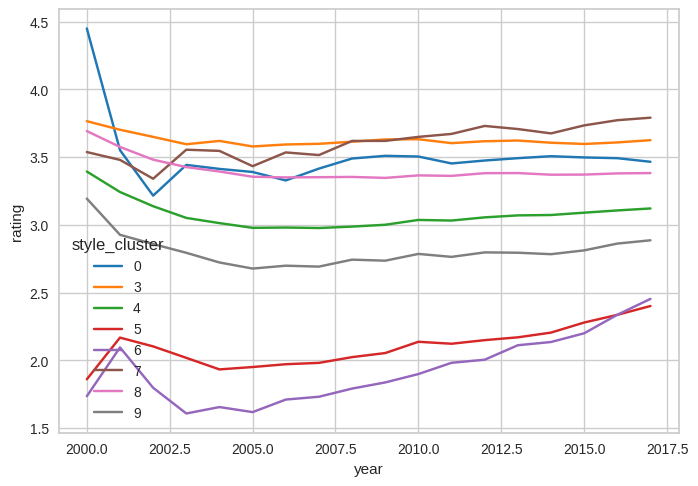

In [ ]:
style_mapping = {elt:line for line in styles_groups for elt in styles_groups[line]}

df_temp1 = df_ratings[['rating', 'beer_id', 'date']]
df_temp2 = df_beers[['beer_id', 'style']]
df_temp3 = pd.merge(df_temp1, df_temp2, on='beer_id', how='inner')
df_temp3['style_cluster'] = df_temp3['style'].apply(lambda x: style_mapping[x])
df_temp3['year'] = pd.to_datetime(df_temp3['date'], unit='s').dt.year
df_temp4 = df_temp3[['rating', 'year', 'style_cluster']]
df_ratings_popularity_mean = df_temp4.groupby(['year', 'style_cluster']).mean()
df_ratings_popularity_mean = df_ratings_popularity_mean.reset_index(drop=False)

sns.lineplot(data=df_ratings_popularity_mean, x='year', y='rating', hue='style_cluster', palette='tab10')
plt.show()

We don't see particular big trends among beers (if we truncate the results of the first years as the data analysis in part 2 showed that the first years do not have much data).

The only exception is the cluster cluster 6. We can check what is in this cluster :

In [ ]:
print('Showing group 6:')
print(styles_groups[6])

print('\nThe center of this cluster is :')
display(df_cluster_centers.loc[6, :])

print('\nHere of few examples of what is in this category :')
display(df_beers[(df_beers['style'].isin(styles_groups[6]))].sample(20)[['beer_name', 'brewery_name', 'style', 'abv']])

Showing group 6:
['Low Alcohol', 'Malt Liquor', 'Saké - Futsu-shu']

The center of this cluster is :


appearance    2.260502
aroma         2.896089
palate        1.886411
taste         2.821925
Name: 6, dtype: float64


Here of few examples of what is in this category :


,beer_name,brewery_name,style,abv
1376,Pabst Blue Ribbon 8° (Chinese),Pabst Brewing Company (China),Low Alcohol,2.50
433497,Bière du Léman Bul,Bière du Léman,Low Alcohol,2.70
71916,Lidl Perlenbacher Alkoholfrei,Frankfurter Brauhaus &#40;TCB Beverages&#41;,Low Alcohol,NaN
66763,Schlossbrauerei Au Holledauer Weisses Alkoholfrei,Schlossbrauerei Au-Hallertau,Low Alcohol,0.01
112375,Leon Steiner Beer Alcohol - Free,Kaufland Česká Republika,Low Alcohol,0.50
58280,Reichenbrander Red Sun,Brauerei Reichenbrand,Low Alcohol,3.40
152167,Strohs Super Strong,Miller Brewing Company &#40;MillerCoors&#41;,Malt Liquor,8.00
120940,Wieckse Lichte,Heineken Nederland,Low Alcohol,3.20
75072,Welde Weizen Alkoholfrei,Weldebräu,Low Alcohol,0.50
78470,Locher Leermond,Locher Appenzeller Bier,Low Alcohol,0.40


This is quite interresting.  We can see that beers with low taste, aroma, palate and taste seems to have gain in ratings average... even if this still quite low compared to the other beers.

We can do the same exercise for the popularity (i.e. the number of ratings) to do that we will show how much each clusters take in percentage of the global ratings space against the other for each year :

Text(0.5, 1.0, 'Count of ratings per year')

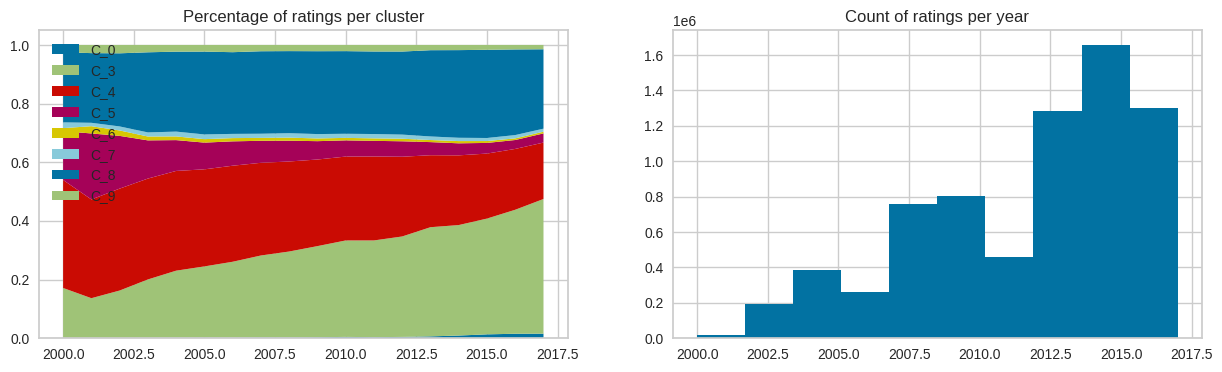

In [ ]:
df_counts_per_cl_year = df_temp4.groupby(['year', 'style_cluster']).count().reset_index(drop=False)
df_counts_per_cl_year = df_counts_per_cl_year.rename(columns={'rating' : 'c'})
rt_counts_per_year = df_counts_per_cl_year.groupby('year').sum().reset_index(drop=False)[['year', 'c']].to_numpy().tolist()
rt_counts_per_year = {elt[0]: elt[1] for elt in rt_counts_per_year}
df_counts_per_cl_year['avg'] = df_counts_per_cl_year.apply(lambda x: x['c']/rt_counts_per_year[x['year']], axis=1)
df_avg_per_cl_year = df_counts_per_cl_year[['year', 'style_cluster', 'avg']]

df_stack_pivot = df_avg_per_cl_year.pivot(index='year', columns='style_cluster', values='avg')


#plt.stackplot(df_stack_pivot)
stack_x = df_stack_pivot.index.to_numpy()
stack_y = df_stack_pivot.to_numpy()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))


ax1.stackplot(stack_x, stack_y.T, labels=[f'C_{elt}' for elt in df_stack_pivot.columns.to_list()])
ax1.set_title('Percentage of ratings per cluster')
le1 = ax1.legend(loc='upper left')

ax2.hist(df_temp3[['year']])
ax2.set_title('Count of ratings per year')

Here we can see a major increase for the cluster 9.
The beers and its properties is listed below :

In [ ]:
print(styles_groups[9])

display(df_cluster_centers.loc[9, :])

['Dortmunder/Helles', 'Premium Lager']


appearance    2.969094
aroma         5.214567
palate        2.775813
taste         5.305186
Name: 9, dtype: float64

This shows that this kind of beers had a big increase of interrests through the years.

### Approach 2 : Semi-manual grouping



In this section we will try again to group beers but this we will use the help of a LLM to group the beers.

For that we will ask the LLM to class all the beer style into 5 more general groups :
 - blond beer
 - pale ale beer
 -  dark beer
 - amber beer
 - white beer
 - acid beer
 - other

The results of these will give the following mapping (this one has also been checked by hand afterward).

In [ ]:
styles_mapping = {
  "Pale Lager": "Blond Beer",
  "Stout": "Dark Beer",
  "Golden Ale/Blond Ale": "Blond Beer",
  "Bitter": "Amber Beer",
  "American Pale Ale": "Pale Ale Beer",
  "Irish Ale": "Amber Beer",
  "Wheat Ale": "White Beer",
  "English Strong Ale": "Amber Beer",
  "Black IPA": "Dark Beer",
  "India Pale Ale (IPA)": "Pale Ale Beer",
  "American Strong Ale ": "Other",
  "Imperial IPA": "Pale Ale Beer",
  "Berliner Weisse": "Acid Beer",
  "Sour/Wild Ale": "Acid Beer",
  "Zwickel/Keller/Landbier": "Other",
  "Saison": "Other",
  "Session IPA": "Pale Ale Beer",
  "Imperial Stout": "Dark Beer",
  "Foreign Stout": "Dark Beer",
  "Porter": "Dark Beer",
  "Spice/Herb/Vegetable": "Other",
  "Pilsener": "Blond Beer",
  "Belgian Ale": "Other",
  "Dry Stout": "Dark Beer",
  "Mild Ale": "Amber Beer",
  "Premium Lager": "Blond Beer",
  "Amber Ale": "Amber Beer",
  "Baltic Porter": "Dark Beer",
  "California Common": "Other",
  "Imperial Porter": "Dark Beer",
  "Dortmunder/Helles": "Blond Beer",
  "Smoked": "Other",
  "Abbey Tripel": "Other",
  "Brown Ale": "Amber Beer",
  "Premium Bitter/ESB": "Amber Beer",
  "Belgian Strong Ale": "Other",
  "Bière de Garde": "Other",
  "German Hefeweizen": "White Beer",
  "English Pale Ale": "Amber Beer",
  "Traditional Ale": "Other",
  "Sweet Stout": "Dark Beer",
  "Kölsch": "Blond Beer",
  "Altbier": "Amber Beer",
  "Sour Red/Brown": "Acid Beer",
  "Fruit Beer": "Other",
  "India Style Lager": "Blond Beer",
  "Lambic Style - Fruit": "Acid Beer",
  "Cider": "Other",
  "Czech Pilsner (Světlý)": "Blond Beer",
  "Witbier": "White Beer",
  "Cream Ale": "Blond Beer",
  "Scotch Ale": "Other",
  "Dunkel/Tmavý": "Dark Beer",
  "Sahti/Gotlandsdricke/Koduõlu": "Other",
  "Heller Bock": "Blond Beer",
  "Amber Lager/Vienna": "Amber Beer",
  "Doppelbock": "Dark Beer",
  "Imperial Pils/Strong Pale Lager": "Blond Beer",
  "Abbey Dubbel": "Other",
  "Dunkelweizen": "Dark Beer",
  "Mead": "Other",
  "Specialty Grain": "Other",
  "Oktoberfest/Märzen": "Amber Beer",
  "Old Ale": "Other",
  "Dunkler Bock": "Dark Beer",
  "Malt Liquor": "Other",
  "Radler/Shandy": "Other",
  "Scottish Ale": "Amber Beer",
  "German Kristallweizen": "White Beer",
  "Schwarzbier": "Dark Beer",
  "Low Alcohol": "Other",
  "Barley Wine": "Other",
  "Grodziskie/Gose/Lichtenhainer": "Other",
  "Weizen Bock": "Blond Beer",
  "Abt/Quadrupel": "Other",
  "Polotmavý": "Amber Beer",
  "Perry": "Other",
  "Eisbock": "Blond Beer",
  "Lambic Style - Gueuze": "Acid Beer",
  "Lambic Style - Unblended": "Acid Beer",
  "Lambic Style - Faro": "Acid Beer",
  "Saké - Daiginjo": "Other",
  "Saké - Namasaké": "Other",
  "Saké - Ginjo": "Other",
  "Saké - Infused": "Other",
  "Saké - Tokubetsu": "Other",
  "Saké - Junmai": "Other",
  "Saké - Nigori": "Other",
  "Saké - Koshu": "Other",
  "Saké - Taru": "Other",
  "Saké - Honjozo": "Other",
  "Saké - Genshu": "Other",
  "Saké - Futsu-shu": "Other",
  "Ice Cider/Ice Perry": "Other"
}

From this we can evaluate the same metrics as before :

In [ ]:
df_rate_style = pd.merge(
    df_ratings[['beer_id', 'rating', 'date']],
    df_beers[['beer_id', 'style']],
    how='inner', on='beer_id'
    )

df_rate_style['year'] = pd.to_datetime(df_temp3['date'], unit='s').dt.year
df_rate_style['style_group'] = df_rate_style['style'].apply(lambda x: styles_mapping[x])

df_rate_style = df_rate_style[['rating', 'year', 'style_group']]

df_rate_avg_style = df_rate_style.groupby(['year', 'style_group']).mean().reset_index(drop=False)


In [ ]:
df_rate_count_style = df_rate_style.groupby(['year', 'style_group']).count().reset_index(drop=False)
df_rate_count_style = df_rate_count_style.rename(columns={'rating': 'c'})

rt_counts_per_year = df_rate_count_style.groupby('year').sum().reset_index(drop=False)[['year', 'c']].to_numpy().tolist()
rt_counts_per_year = {elt[0]: elt[1] for elt in rt_counts_per_year}
df_rate_count_style['avg'] = df_rate_count_style.apply(lambda x: x['c']/rt_counts_per_year[x['year']], axis=1)
df_rate_c_avg_pivot = df_rate_count_style.pivot(index='year', columns='style_group', values='avg')


<ipython-input-25-1e35de1b8d53>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  rt_counts_per_year = df_rate_count_style.groupby('year').sum().reset_index(drop=False)[['year', 'c']].to_numpy().tolist()


We can start again by watching the rating average on each style.

Text(0.5, 1.0, 'Rating average per group')

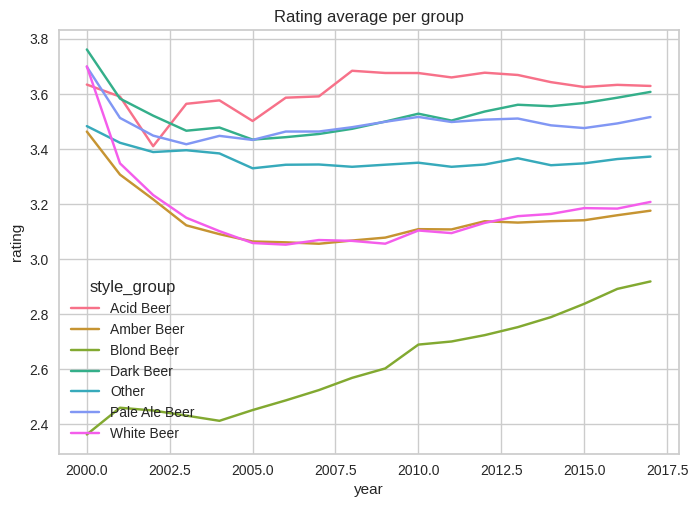

In [ ]:
fig, ax = plt.subplots()

sns.lineplot(df_rate_avg_style, x='year', y='rating', hue='style_group', ax=ax)
ax.set_title('Rating average per group')

Text(0.5, 1.0, 'Count of ratings per year')

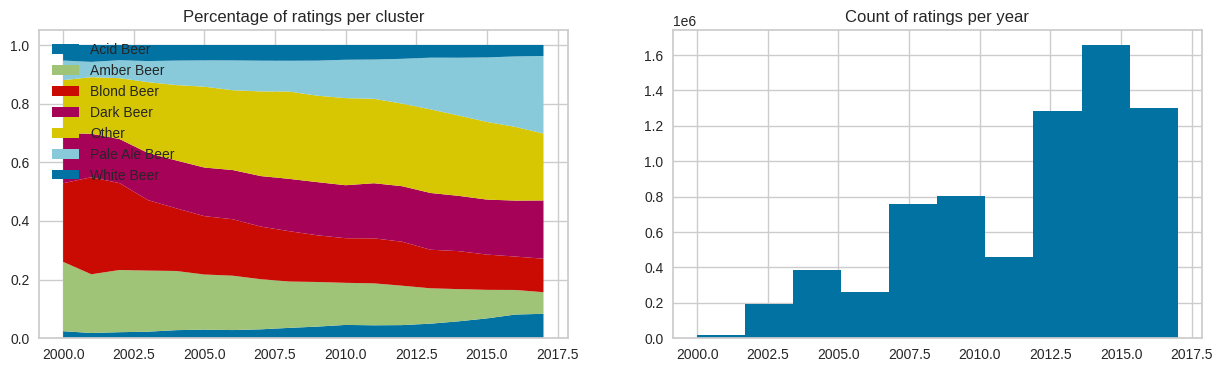

In [ ]:
stack_x = df_rate_c_avg_pivot.index.to_numpy()
stack_y = df_rate_c_avg_pivot.to_numpy()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))


ax1.stackplot(stack_x, stack_y.T, labels=df_rate_c_avg_pivot.columns.to_list())
ax1.set_title('Percentage of ratings per cluster')
le1 = ax1.legend(loc='upper left')

ax2.hist(df_temp3[['year']])
ax2.set_title('Count of ratings per year')

We can conclude taht....

### Approach 3 : No grouping

In this scenario we won't group the beers style together but directly from the beer styles. As there are a lot of beers to analyze we will use a method which is a little different : we will analyze our previous metric : popularity (= the number of rating for each beer) and the rating's average in 2003 (first time with a little bit of data) and in 2015 (before that the ratings of the website decrease a lot) and see the difference.

In [ ]:
df_rate_style = pd.merge(
    df_ratings[['beer_id', 'rating', 'date']],
    df_beers[['beer_id', 'style']],
    how='inner', on='beer_id'
    )

df_rate_style['year'] = pd.to_datetime(df_rate_style['date'], unit='s').dt.year
df_rate_style = df_rate_style[['rating', 'style', 'year']]
df_rate_style_mean = df_rate_style.groupby(['style', 'year']).mean().reset_index(drop=False)


df_rate_style_mean = df_rate_style_mean.pivot(index='style', columns='year', values='rating').reset_index(drop=False)
df_rate_style_mean_sample = df_rate_style_mean[['style', 2003, 2015]]
df_rate_style_mean_sample.insert(3, "rate", df_rate_style_mean_sample.loc[:,2015]/df_rate_style_mean_sample.loc[:,2003])
df_rate_style_rate = df_rate_style_mean_sample.sort_values('rate').dropna()

print('Lowest growth :')
display(df_rate_style_rate.head(5))
print('Highest growth :')
display(df_rate_style_rate.tail(5))

Lowest growth :


year,style,2003,2015,rate
2,Abt/Quadrupel,4.041836,3.745358,0.926648
27,Eisbock,3.835071,3.558133,0.927788
92,Zwickel/Keller/Landbier,3.301852,3.078521,0.932362
89,Weizen Bock,3.757436,3.508991,0.933879
63,Sahti/Gotlandsdricke/Koduõlu,3.528571,3.311859,0.938584


Highest growth :


year,style,2003,2015,rate
19,Cream Ale,2.753750,3.158806,1.147092
90,Wheat Ale,2.748804,3.208927,1.167390
50,Malt Liquor,1.646330,2.155828,1.309475
62,Radler/Shandy,1.742453,2.315076,1.328630
49,Low Alcohol,1.554516,2.219718,1.427915


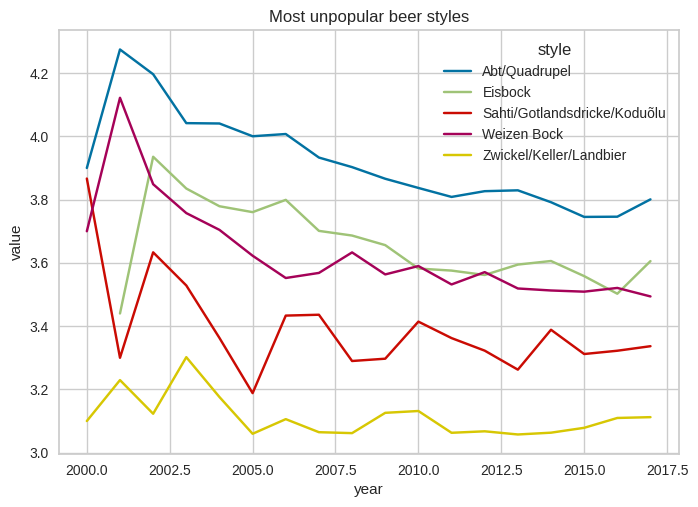

In [ ]:
unpopular_beers = ['Abt/Quadrupel', 'Eisbock', 'Zwickel/Keller/Landbier', 'Weizen Bock', 'Sahti/Gotlandsdricke/Koduõlu']
popular_beers = ['Cream Ale', 'Wheat Ale', 'Malt Liquor', 'Radler/Shandy', 'Low Alcohol']

#df_rate_style_mean
unpopular_b_df = df_rate_style_mean[df_rate_style_mean['style'].isin(unpopular_beers)]
unpopular_b_df = pd.melt(unpopular_b_df, id_vars=['style'], value_vars=list(range(2000, 2018)))


sns.lineplot(unpopular_b_df, hue='style', x='year', y='value')
plt.title('Most unpopular beer styles')
plt.show()

On this plot we don't see major differences

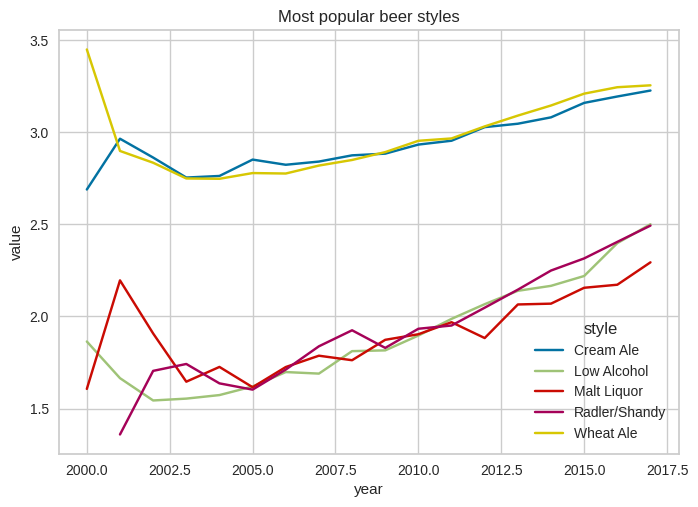

In [ ]:
popular_beers = ['Cream Ale', 'Wheat Ale', 'Malt Liquor', 'Radler/Shandy', 'Low Alcohol']

#df_rate_style_mean
popular_b_df = df_rate_style_mean[df_rate_style_mean['style'].isin(popular_beers)]
popular_b_df = pd.melt(popular_b_df, id_vars=['style'], value_vars=list(range(2000, 2018)))

sns.lineplot(popular_b_df, hue='style', x='year', y='value')
plt.title('Most popular beer styles')
plt.show()

This result show about the same as some of the previous results (beers badly graded have a bit better grade through time).

Let's do the same now for popularity :

In [ ]:
df_rate_style = pd.merge(
    df_ratings[['beer_id', 'rating', 'date']],
    df_beers[['beer_id', 'style']],
    how='inner', on='beer_id'
    )

df_rate_style['year'] = pd.to_datetime(df_rate_style['date'], unit='s').dt.year

df_rate_style = df_rate_style[df_rate_style['year'].isin([2003, 2015])]
df_rate_style = df_rate_style[['beer_id', 'style', 'year']]
df_rate_style = df_rate_style.groupby(['year', 'style']).count()
df_rate_style = df_rate_style.rename(columns={'beer_id' : 'c'}).reset_index(drop=False)
df_rate_style = df_rate_style.pivot(columns='year', values='c', index='style').reset_index(drop=False)
#df_rate_style = df_rate_style.rename_axis('index', axis=0)
df_rate_style['rate'] = df_rate_style[2015] / df_rate_style[2003]
df_rate_style = df_rate_style.sort_values(by='rate', ascending=False)
display(df_rate_style[df_rate_style['rate'].isna()])

print('Those date does not seem really important as the number of rating is very low')
df_rate_style = df_rate_style.dropna()

year,style,2003,2015,rate
65,Saké - Daiginjo,NaN,3.0,NaN
66,Saké - Futsu-shu,NaN,8.0,NaN
67,Saké - Genshu,NaN,7.0,NaN
68,Saké - Ginjo,NaN,7.0,NaN
69,Saké - Infused,NaN,6.0,NaN
70,Saké - Junmai,NaN,49.0,NaN
71,Saké - Namasaké,NaN,1.0,NaN
72,Saké - Nigori,NaN,2.0,NaN
73,Saké - Taru,NaN,2.0,NaN
74,Saké - Tokubetsu,NaN,2.0,NaN


Those date does not seem really important as the number of rating is very low


In order to have result in main trends (beers that have been quite a lot rated at the beginning) we will only show data that have more than a 500 reviews in 2003.

Before further investigation we can also. Let's also add information about those per-beer trend behaves compared to the dataframe.

In [ ]:
total_ratings_sum = df_rate_style[[2003, 2015]].sum()
total_r_2003 = total_ratings_sum.loc[2003]
total_r_2015 = total_ratings_sum.loc[2015]

global_trend = total_r_2015 / total_r_2003
print(f' The global trend is {global_trend:.2f}')

df_rate_style['rate_vs_global'] = df_rate_style['rate'] / global_trend

print('Highest growth :')
display((df_rate_style[df_rate_style[2003] > 500]).head(10))

print('Lowest growth')
display((df_rate_style[df_rate_style[2003] > 500]).tail(10))

 The global trend is 7.43
Highest growth :


year,style,2003,2015,rate,rate_vs_global
37,Imperial IPA,815.0,37648.0,46.193865,6.218410
64,Saison,835.0,37799.0,45.268263,6.093810
40,Imperial Stout,2054.0,48505.0,23.614898,3.178931
41,India Pale Ale (IPA),3760.0,87738.0,23.334574,3.141195
7,American Strong Ale,738.0,10556.0,14.303523,1.925476
80,Sour Red/Brown,644.0,8135.0,12.631988,1.700461
6,American Pale Ale,3546.0,43443.0,12.251269,1.649211
79,Smoked,685.0,8362.0,12.207299,1.643292
83,Spice/Herb/Vegetable,1715.0,20687.0,12.062391,1.623785
10,Belgian Ale,2442.0,20835.0,8.531941,1.148531


Lowest growth


year,style,2003,2015,rate,rate_vs_global
0,Abbey Dubbel,1845.0,6465.0,3.504065,0.471701
43,Irish Ale,805.0,2728.0,3.388820,0.456188
21,Doppelbock,1602.0,5046.0,3.149813,0.424014
28,English Pale Ale,1149.0,3485.0,3.033072,0.408299
29,English Strong Ale,2089.0,5477.0,2.621829,0.352939
23,Dry Stout,1442.0,3693.0,2.561026,0.344754
5,Amber Lager/Vienna,2855.0,6492.0,2.273905,0.306103
60,Premium Bitter/ESB,4120.0,8756.0,2.125243,0.286091
50,Malt Liquor,872.0,1673.0,1.918578,0.258270
55,Pale Lager,13729.0,22216.0,1.618180,0.217832


This give a good idea about which beers took a became popular and unpopular.

We can plot those 2 categories trough the years w.r.t. to the global number of ratings.

In [ ]:
popular_beers =  ['Imperial IPA', 'Saison', 'Imperial Stout', 'India Pale Ale (IPA)']
unpopular_beers = [
    'Pale Lager', 'Malt Liquor', 'Premium Bitter/ESB', 'Amber Lager/Vienna',
    'Dry Stout', 'English Strong Ale'
    ]
df_r_plot_styles = pd.merge(
    df_ratings[['beer_id', 'date']],
    df_beers[['beer_id', 'style']],
    how='inner', on='beer_id'
    )

df_r_plot_styles['year'] = pd.to_datetime(df_r_plot_styles['date'], unit='s').dt.year

df_r_plot_styles = df_r_plot_styles[['year', 'style', 'beer_id']].groupby(['year', 'style']).count().reset_index(drop=False)
df_r_plot_styles = df_r_plot_styles.rename(columns={'beer_id' : 'c'})

df_r_plot_styles = df_r_plot_styles.pivot(index='style', columns='year', values='c').reset_index(drop=False)

sr_sum_per_year = df_r_plot_styles[list(range(2000, 2018))].sum()
for i in range(2000, 2018):
  df_r_plot_styles.loc[:, i] = df_r_plot_styles.loc[:, i] / sr_sum_per_year.loc[i]

df_r_plot_styles

year,style,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Abbey Dubbel,0.012992,0.014107,0.014972,0.016266,0.015812,0.014452,0.014678,0.015161,0.013340,0.012031,0.011660,0.010870,0.010009,0.009352,0.008861,0.007672,0.006103,0.005483
1,Abbey Tripel,0.014848,0.014646,0.017969,0.021159,0.021279,0.022721,0.021064,0.020782,0.020622,0.019309,0.018434,0.016850,0.016363,0.015737,0.015276,0.013381,0.012466,0.011134
2,Abt/Quadrupel,0.004826,0.005546,0.007607,0.009125,0.010068,0.009592,0.009674,0.012020,0.010567,0.010982,0.009413,0.008966,0.009645,0.010204,0.008932,0.008346,0.007918,0.007908
3,Altbier,0.005568,0.005761,0.005943,0.006136,0.006869,0.007215,0.006072,0.005114,0.004529,0.005050,0.004530,0.004688,0.003995,0.003909,0.003530,0.003243,0.002879,0.002336
4,Amber Ale,0.036748,0.025199,0.026084,0.027199,0.025766,0.024752,0.022754,0.023256,0.022549,0.020588,0.018655,0.017994,0.018759,0.019718,0.018588,0.018588,0.016539,0.014413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,Traditional Ale,0.005197,0.004792,0.006680,0.006224,0.006616,0.006298,0.005557,0.006310,0.005718,0.005265,0.005868,0.005686,0.005475,0.005210,0.005069,0.004062,0.004041,0.003828
89,Weizen Bock,0.001856,0.002692,0.003645,0.003438,0.003182,0.003286,0.003644,0.006897,0.006460,0.005653,0.005076,0.005629,0.004759,0.004530,0.004596,0.004012,0.003513,0.003688
90,Wheat Ale,0.012992,0.011307,0.011086,0.011056,0.010369,0.009880,0.010784,0.011883,0.012821,0.013737,0.011261,0.011210,0.010059,0.010268,0.010420,0.011034,0.010442,0.010773
91,Witbier,0.015219,0.018253,0.014794,0.016883,0.017406,0.017318,0.016364,0.017672,0.017807,0.016748,0.016402,0.015521,0.015045,0.014225,0.014306,0.014202,0.013140,0.012059


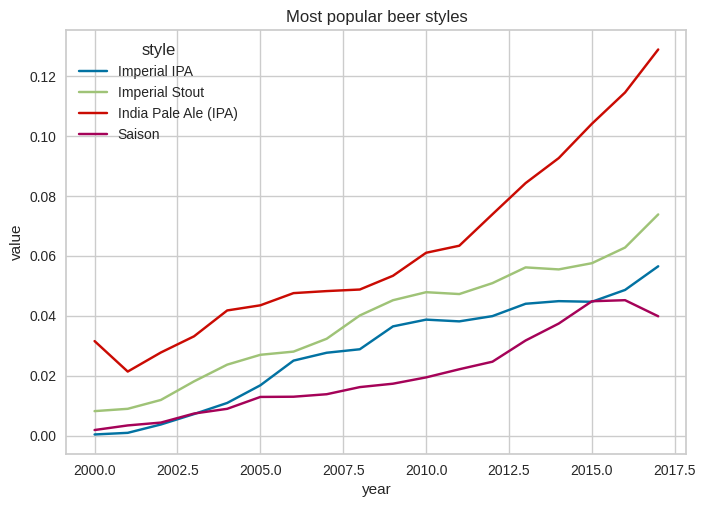

In [ ]:
popular_beers_df = df_r_plot_styles[df_r_plot_styles['style'].isin(popular_beers)]
popular_beers_df = pd.melt(popular_beers_df, id_vars=['style'], value_vars=list(range(2000, 2018)))

#import to be used later
popular_beers_df_px = popular_beers_df

sns.lineplot(popular_beers_df, hue='style', x='year', y='value')
plt.title('Most popular beer styles')
plt.show()

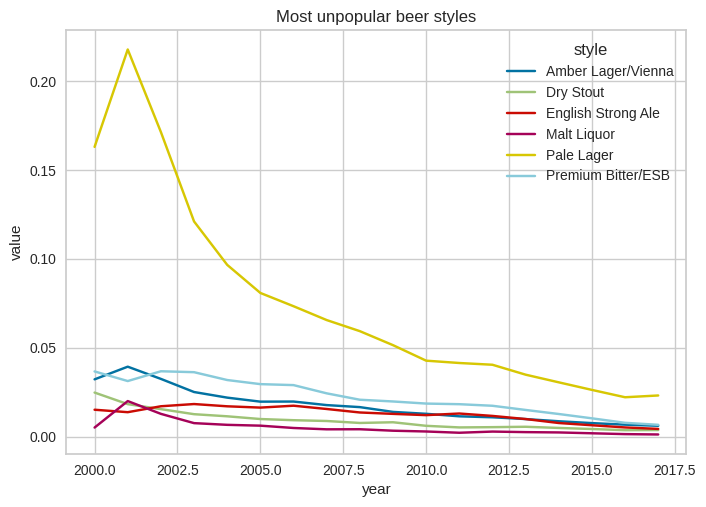

In [ ]:
unpopular_beers_df = df_r_plot_styles[df_r_plot_styles['style'].isin(unpopular_beers)]
unpopular_beers_df = pd.melt(unpopular_beers_df, id_vars=['style'], value_vars=list(range(2000, 2018)))


sns.lineplot(unpopular_beers_df, hue='style', x='year', y='value')
plt.title('Most unpopular beer styles')
plt.show()

### Conclusion

## Research question 2

**Question:** Which aspects of beers are associated with the popularity of beer the most? Does the importance of these aspects change over time?

In [ ]:
df_rate_style_aspects = pd.merge(
    df_ratings[['beer_id', 'rating', 'date','appearance','aroma','palate','taste','overall']],
    df_beers[['beer_id', 'style']],
    how='inner', on='beer_id'
    )

df_rate_style_aspects['year'] = pd.to_datetime(df_temp3['date'], unit='s').dt.year
df_rate_style_aspects['month'] = pd.to_datetime(df_temp3['date'], unit='s').dt.month
df_rate_style_aspects['style_group'] = df_rate_style_aspects['style'].apply(lambda x: styles_mapping[x])

df_rate_style_aspects_year = df_rate_style_aspects.groupby(['year','style_group']).mean().reset_index(drop=False)
df_rate_style_aspects_year['count'] = df_rate_style_aspects.groupby(['year','style_group']).count().reset_index(drop=False)['rating']
annual_reviews_count = df_rate_style_aspects.groupby(['year']).count()['rating']
annual_reviews_count =pd.DataFrame(annual_reviews_count)
annual_reviews_count = annual_reviews_count.reset_index(drop=False)
annual_reviews_count = annual_reviews_count.rename(columns={"rating": "annual_count"})
year_to_count = dict(zip(annual_reviews_count['year'], annual_reviews_count['annual_count']))


df_rate_style_aspects_year['count_normalized'] = df_rate_style_aspects_year['count'] / df_rate_style_aspects_year['year'].map(year_to_count)
df_rate_style_aspects_year


<ipython-input-36-4cb9c2b12aaa>:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_rate_style_aspects_year = df_rate_style_aspects.groupby(['year','style_group']).mean().reset_index(drop=False)


,year,style_group,beer_id,rating,date,appearance,aroma,palate,taste,overall,month,count,count_normalized
0,2000,Acid Beer,3170.323077,3.633846,9.708051e+08,3.846154,7.507692,3.538462,7.046154,14.400000,9.692308,65,0.024128
1,2000,Amber Beer,5195.105181,3.463108,9.710333e+08,3.697017,6.507064,3.511774,6.751962,14.163265,9.722135,637,0.236451
2,2000,Blond Beer,5044.563712,2.363158,9.697224e+08,2.670360,4.222992,2.574792,4.732687,9.430748,9.254848,722,0.268003
3,2000,Dark Beer,2758.517391,3.761304,9.705057e+08,4.089130,7.195652,3.828261,7.339130,15.160870,9.534783,460,0.170750
4,2000,Other,4843.390144,3.482957,9.719384e+08,3.613963,6.885010,3.480493,6.790554,14.059548,10.114990,487,0.180772
...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,2017,Blond Beer,268629.966867,2.918911,1.492805e+09,3.220997,5.589386,3.038140,5.736958,11.603557,4.181501,55322,0.114040
122,2017,Dark Beer,347138.894589,3.607241,1.491760e+09,3.747834,7.094309,3.574986,7.133299,14.521897,3.785205,96385,0.198687
123,2017,Other,329562.243472,3.372299,1.492328e+09,3.464638,6.649421,3.360732,6.677803,13.570217,4.000362,110600,0.227990
124,2017,Pale Ale Beer,393910.689438,3.516038,1.492715e+09,3.534329,6.960938,3.470392,6.958710,14.236045,4.150147,128361,0.264602


In [ ]:
df_rate_style_aspects_year['NomalCount:Ratings'] = df_rate_style_aspects_year['count_normalized'] * df_rate_style_aspects_year['rating']
df_rate_style_aspects_year

,year,style_group,beer_id,rating,date,appearance,aroma,palate,taste,overall,month,count,count_normalized,NomalCount:Ratings
0,2000,Acid Beer,3170.323077,3.633846,9.708051e+08,3.846154,7.507692,3.538462,7.046154,14.400000,9.692308,65,0.024128,0.087676
1,2000,Amber Beer,5195.105181,3.463108,9.710333e+08,3.697017,6.507064,3.511774,6.751962,14.163265,9.722135,637,0.236451,0.818857
2,2000,Blond Beer,5044.563712,2.363158,9.697224e+08,2.670360,4.222992,2.574792,4.732687,9.430748,9.254848,722,0.268003,0.633333
3,2000,Dark Beer,2758.517391,3.761304,9.705057e+08,4.089130,7.195652,3.828261,7.339130,15.160870,9.534783,460,0.170750,0.642242
4,2000,Other,4843.390144,3.482957,9.719384e+08,3.613963,6.885010,3.480493,6.790554,14.059548,10.114990,487,0.180772,0.629621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,2017,Blond Beer,268629.966867,2.918911,1.492805e+09,3.220997,5.589386,3.038140,5.736958,11.603557,4.181501,55322,0.114040,0.332874
122,2017,Dark Beer,347138.894589,3.607241,1.491760e+09,3.747834,7.094309,3.574986,7.133299,14.521897,3.785205,96385,0.198687,0.716713
123,2017,Other,329562.243472,3.372299,1.492328e+09,3.464638,6.649421,3.360732,6.677803,13.570217,4.000362,110600,0.227990,0.768851
124,2017,Pale Ale Beer,393910.689438,3.516038,1.492715e+09,3.534329,6.960938,3.470392,6.958710,14.236045,4.150147,128361,0.264602,0.930352


Before checking the impact of different aspects of the beer on its poulairty lets check if each beer styles does have a stabel and similar perception for the users over the time. So we will plot the ratings for each aspects through the time.

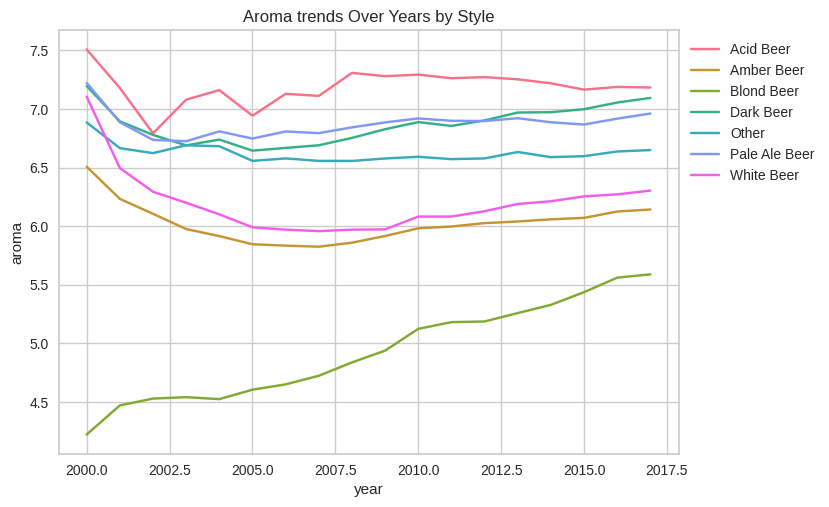

In [ ]:
sns.lineplot(data=df_rate_style_aspects_year, x='year', y='aroma', hue='style_group')
plt.title('Aroma trends Over Years by Style')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

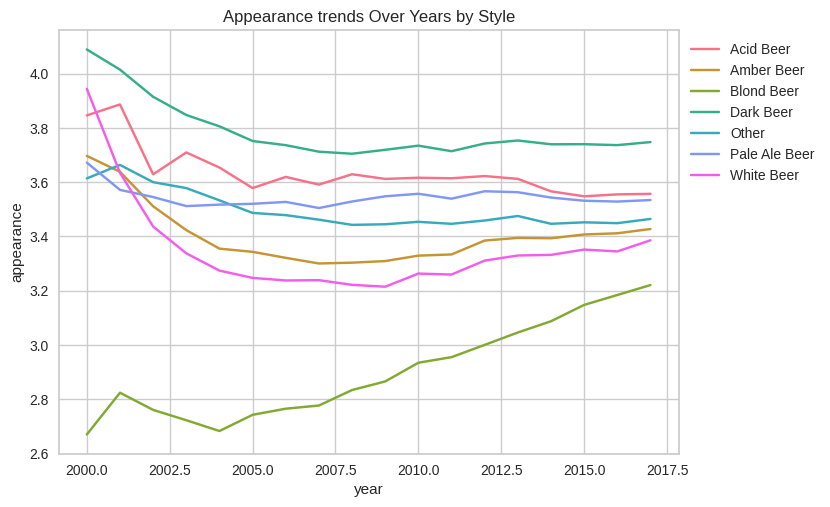

In [ ]:
sns.lineplot(data=df_rate_style_aspects_year, x='year', y='appearance', hue='style_group')
plt.title('Appearance trends Over Years by Style')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

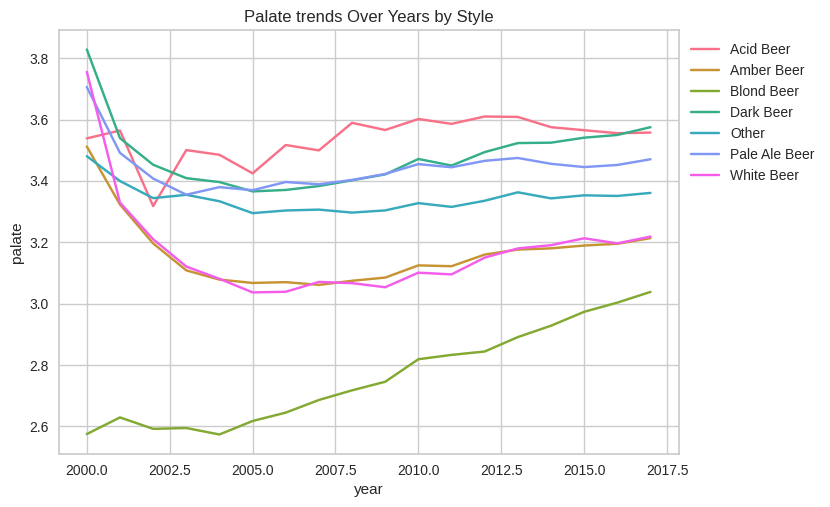

In [ ]:
sns.lineplot(data=df_rate_style_aspects_year, x='year', y='palate', hue='style_group')
plt.title('Palate trends Over Years by Style')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

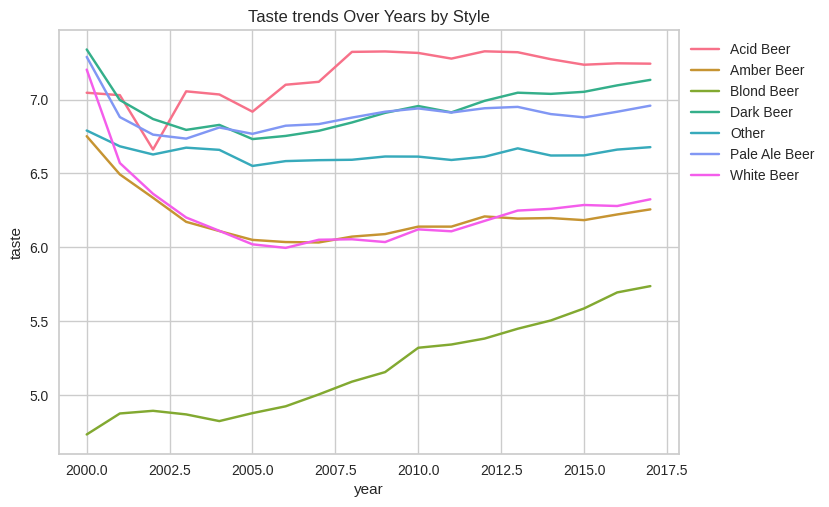

In [ ]:
sns.lineplot(data=df_rate_style_aspects_year, x='year', y='taste', hue='style_group')
plt.title('Taste trends Over Years by Style')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

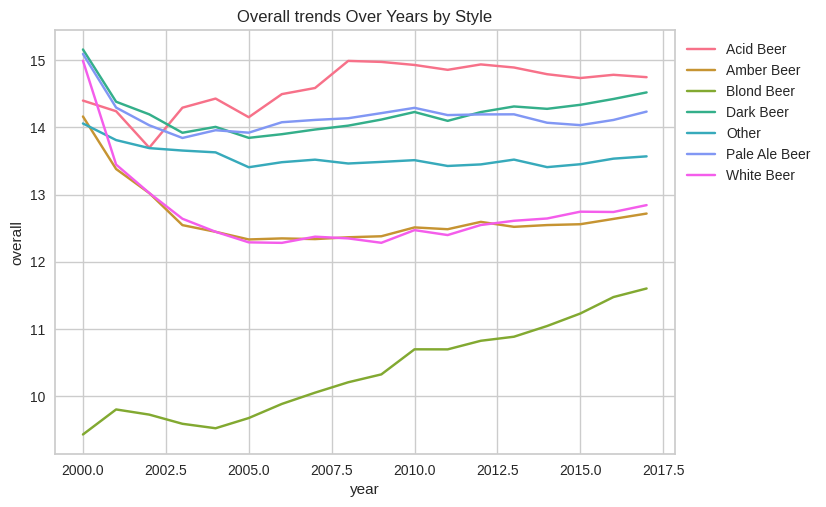

In [ ]:
sns.lineplot(data=df_rate_style_aspects_year, x='year', y='overall', hue='style_group')
plt.title('Overall trends Over Years by Style')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

As we see only blond beer has a significant increasing trend in different metrics. And the perception and ratings of users for different styles is quite stable. To check if the number of reviews for different styles has an effect we will plot the count of reviews per year, per beer style.

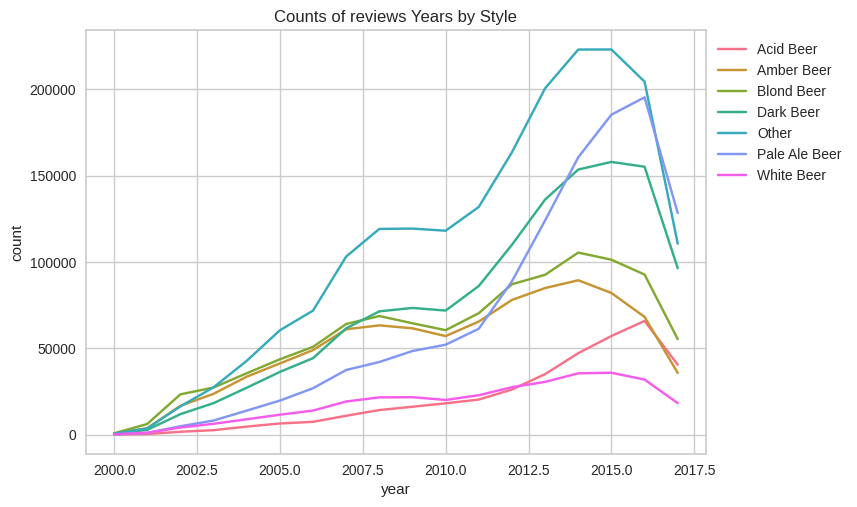

In [ ]:
sns.lineplot(data=df_rate_style_aspects_year, x='year', y='count', hue='style_group')
plt.title('Counts of reviews Years by Style')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

As we can see the  trends are similar for differnet beer styles.


### Regression

To answer this question we should define the popularity in this context. For the research question we define the popularity as follow.

Populairty = scaled number of reviews per beer style per year * average rating per beer style per year.

Now we have our dependant varibale, lets talk about the independant varibales. We are going to  use aroma, appearance, taste, pallate and overall rate as our IVs. But before construcitng the regression we need to make sure our independant variables are indeed independant. Therefore, we need to check if they have corrolation with eachother or not. Unfortunately, these metrics are corrolated with each otehr therefore, we can not construct our regression and therefore we can not conclude that any of these metric is more significant because they are related.



In [ ]:
df_rate_style_aspects_year[['count_normalized','appearance','aroma','palate','taste','overall']].corr()

,count_normalized,appearance,aroma,palate,taste,overall
count_normalized,1.000000,-0.169633,-0.260511,-0.216018,-0.229521,-0.227781
appearance,-0.169633,1.000000,0.918531,0.941363,0.927161,0.933727
aroma,-0.260511,0.918531,1.000000,0.981100,0.993781,0.991285
palate,-0.216018,0.941363,0.981100,1.000000,0.989634,0.989509
taste,-0.229521,0.927161,0.993781,0.989634,1.000000,0.998008
overall,-0.227781,0.933727,0.991285,0.989509,0.998008,1.000000


In [ ]:
df_ratings[['rating','appearance','aroma','palate','taste','overall']].corr()

,rating,appearance,aroma,palate,taste,overall
rating,1.000000,0.618909,0.876174,0.752301,0.925556,0.956429
appearance,0.618909,1.000000,0.474875,0.548253,0.483462,0.496114
aroma,0.876174,0.474875,1.000000,0.565140,0.793550,0.773399
palate,0.752301,0.548253,0.565140,1.000000,0.654290,0.655906
taste,0.925556,0.483462,0.793550,0.654290,1.000000,0.856336
overall,0.956429,0.496114,0.773399,0.655906,0.856336,1.000000


## Research question 3
What is the estimated lag time between introducing a new beer and the gain of popularity on average?

To answer this question, two important metrics need to be defined, the introduction date of the beer and the popularity gain threshold. By 'popularity gain threshold' we mean a metric that states that the beer has or hasn't reach its popularity.

As we want to find the time between the beer release and its popularity gain (that we measure on the number of ratings) the beer needs to have a good amount of ratings.

In [ ]:
# Getting a basic description of the bumber of ratings
df_beers.nbr_ratings.describe()

count    442081.000000
mean         16.110337
std          80.988812
min           0.000000
25%           1.000000
50%           3.000000
75%           9.000000
max        5272.000000
Name: nbr_ratings, dtype: float64

On the 442k beers, the mean number of ratings is 16, but the median is only at 3. We need a way higher number of ratings to assess popularity. We will arbitraly set this minimum treshold at 500 ratings.

In [ ]:
print('The number of beer with 500 ratings or more is',len(df_beers.loc[df_beers['nbr_ratings']>=500]))


The number of beer with 500 ratings or more is 1629


In [ ]:
#df_beers_popular_date

### Introduction date
Unfortunately, the introduction date is not given in the dataset. And as we have more than 442k beers usually coming from small breweries it is impossible to browse the internet looking for the release date of each beer.

However we have access to the ratings date, we could therefore estimate the release date taking the fist rating date. This of course will under-estimate the age of the beer, but we could use some tricks to make this as precise as posssible.
Before taking any choice lets look back at the histogram of ratings dates.

In [ ]:
# Creating a new dataframe with date time and not UNIX
df_ratings_date=pd.DataFrame()
df_ratings_date['beer_id']=df_ratings['beer_id']
df_ratings_date['date'] =pd.to_datetime(df_ratings['date'], unit='s')

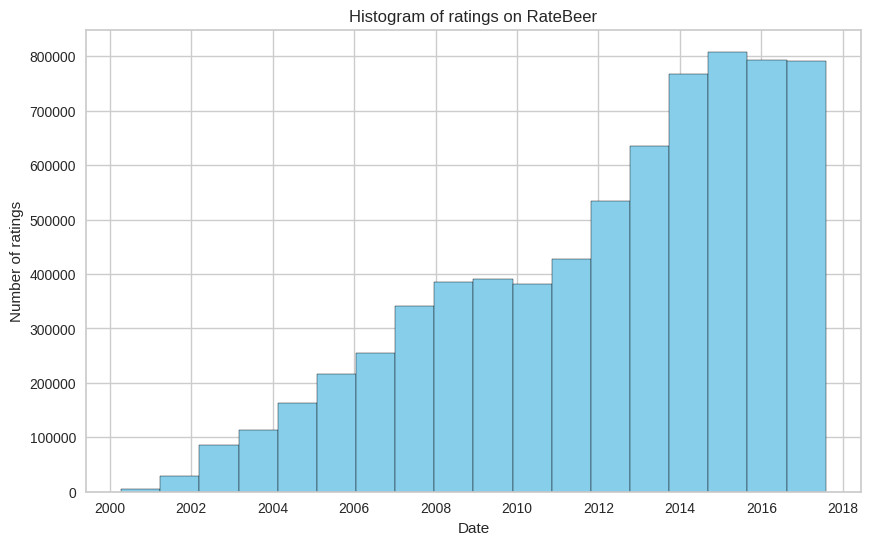

In [ ]:
# Histogram of the number of ratings on the website

plt.figure(figsize=(10, 6))
plt.hist(df_ratings_date.date, bins=18,color='skyblue', edgecolor='black')
#plt.yscale('log')

# Adding labels and title
plt.title('Histogram of ratings on RateBeer')
plt.xlabel('Date')
plt.ylabel('Number of ratings')


# Show the plot
plt.show()


In [ ]:
print('The first rating date is', df_ratings_date.date.min()
,' and the last date is', df_ratings_date.date.max())

The first rating date is 2000-04-12 10:00:00  and the last date is 2017-07-31 10:00:00


We see that the years 2000 and 2017 are not complete. Such that beers released in 2017  might not have enough time to reach its 'popularity'. In addition to that, the beers having their first ratings in 2000 (and probably 2001) were probably released (way) before this date, but they had to have a first rating once the website was active.

But first, lets find those first rating dates.

In [ ]:
# Find the earliest date for each 'beer_id'
earliest_dates = df_ratings.groupby('beer_id')['date'].min().reset_index()
earliest_dates.columns = ['beer_id', 'earliest_rating']
earliest_dates['release_date'] = pd.to_datetime(earliest_dates['earliest_rating'], unit='s')
display(earliest_dates)
print('The number of beers with an estimated release date is', len(earliest_dates))

,beer_id,earliest_rating,release_date
0,1,958298400,2000-05-14 10:00:00
1,2,968234400,2000-09-06 10:00:00
2,3,973162800,2000-11-02 11:00:00
3,4,974890800,2000-11-22 11:00:00
4,5,974890800,2000-11-22 11:00:00
...,...,...,...
396685,536472,1500976800,2017-07-25 10:00:00
396686,536473,1500976800,2017-07-25 10:00:00
396687,536474,1499076000,2017-07-03 10:00:00
396688,536475,1501149600,2017-07-27 10:00:00


The number of beers with an estimated release date is 396690


In [ ]:
# Setting unix stamps to the corresponding dates of interest
first_date = datetime.datetime(2002, 1, 1, 0, 0)# First date that we want to
first_unix=time.mktime(first_date.timetuple())# analyze for RQ3
last_date =datetime.datetime(2016, 12, 31, 23, 59) # Last date that we want to
last_unix=time.mktime(last_date.timetuple())# analyze for RQ3

# Filtering through the loc. function
usefull_dates = earliest_dates.loc[(earliest_dates['earliest_rating']>first_unix)
&(earliest_dates['earliest_rating']<last_unix)]
print('The number of beers with optimal release dates is', len(usefull_dates))

The number of beers with optimal release dates is 345370


This simple 'filtering' enabled us to delete around 50k beers. Now lets plot a histogram of our dates, merge 'usefull_dates' with 'df_beers' and look at what popularity is.

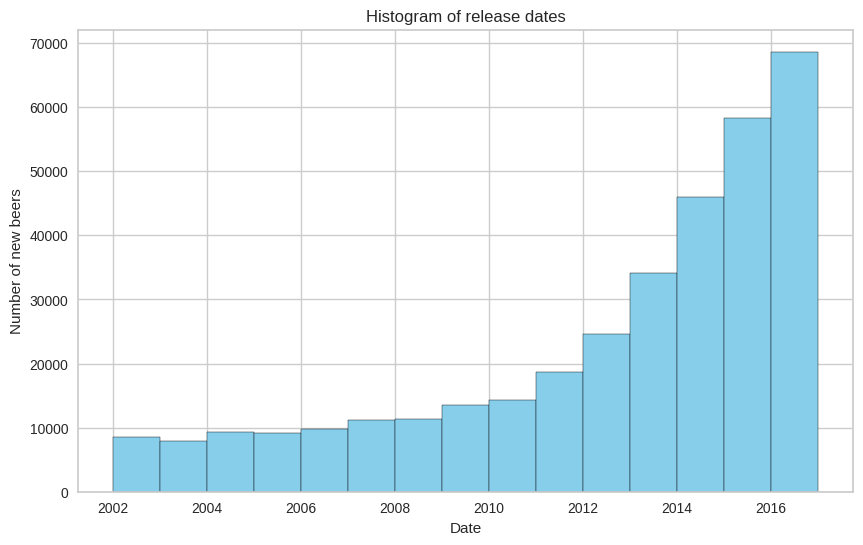

In [ ]:
# Histogram of the number of beer released by date

plt.figure(figsize=(10, 6))
plt.hist(usefull_dates.release_date, bins=15,color='skyblue', edgecolor='black')
#plt.yscale('log')

# Adding labels and title
plt.title('Histogram of release dates')
plt.xlabel('Date')
plt.ylabel('Number of new beers')


# Show the plot
plt.show()

In [ ]:
# Merge of 'usefull_dates' and 'df_beers' on right as we want only beers
# with our estimates of release date
df_beers_date = df_beers.merge(usefull_dates, how='right', on=['beer_id'])
display(df_beers_date)
# And we also have to keep only these beers in the df_ratings_date
usefull_beers_list = df_beers_date.beer_id
df_ratings_date=df_ratings_date[df_ratings_date['beer_id'].isin(usefull_beers_list)]
display(df_ratings_date)

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,overall_score,style_score,avg,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings,earliest_rating,release_date
0,12,Adnams The Bitter (Bottle/Can),3,Adnams,Bitter,471,52.0,95.0,3.23,4.5,3.233758,NaN,0,NaN,1012993200,2002-02-06 11:00:00
1,18,Adler Brau Marquette Pilsner,5,Appleton Brewing/Adler Brau,Pilsener,5,NaN,NaN,2.65,5.7,2.620000,NaN,0,NaN,1040295600,2002-12-19 11:00:00
2,19,Adler Brau Belgium-Luxembourg Mixed Up Ale,5,Appleton Brewing/Adler Brau,Belgian Ale,2,NaN,NaN,3.52,5.8,4.150000,NaN,0,NaN,1033552800,2002-10-02 10:00:00
3,21,Barley Creek Cliffhanger Light Ale,6,Barley Creek Brewing Co.,Golden Ale/Blond Ale,24,7.0,2.0,2.08,NaN,2.000000,NaN,0,NaN,1021024800,2002-05-10 10:00:00
4,22,Barley Creek Antler Brown Ale,6,Barley Creek Brewing Co.,Brown Ale,86,20.0,12.0,2.77,4.8,2.790698,NaN,0,NaN,1020333600,2002-05-02 10:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345365,533932,Lovibonds Henley Gold (post 2009),6792,Lovibonds Brewery,Wheat Ale,25,NaN,NaN,3.13,4.6,3.156000,NaN,0,NaN,1271412000,2010-04-16 10:00:00
345366,534175,Arany Ászok Hűsítő Citrom,2241,Dreher Sörgyárak (SABMiller),Radler/Shandy,16,3.0,36.0,1.98,2.0,1.762500,NaN,0,NaN,1369216800,2013-05-22 10:00:00
345367,534566,Rudgate Jorvik Blonde (Bottle),2292,Rudgate,Golden Ale/Blond Ale,6,NaN,NaN,3.07,4.6,3.166667,NaN,0,NaN,1374055200,2013-07-17 10:00:00
345368,535257,°Plato Salish Sea IPA,21442,°Plato Brewing,India Pale Ale (IPA),11,53.0,34.0,3.23,6.4,3.336364,NaN,0,NaN,1416654000,2014-11-22 11:00:00


,beer_id,date
0,410549,2016-04-26 10:00:00
1,105273,2017-02-17 11:00:00
2,105273,2016-06-24 10:00:00
3,105273,2016-01-01 11:00:00
4,105273,2015-10-23 10:00:00
...,...,...
69,220897,2014-09-18 10:00:00
70,220897,2013-12-01 11:00:00
71,220898,2014-11-04 11:00:00
72,220898,2014-09-16 10:00:00


### Gain of popularity
As we aim at estimating (and explaining ?) the delay between the introduction of the beer and its popularity gain, it is important to define what a 'gain of popularity' is.We have stated above, that to be considered popular, a beer has to have 500 ratings or more. Lets apply this filter and look at the histogram of ratings for one of the beers.

In [ ]:
df_beers_date_popular = df_beers_date.loc[df_beers_date['nbr_ratings']>=500]
display(df_beers_date_popular)

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,overall_score,style_score,avg,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings,earliest_rating,release_date
23,189,Stiegl Goldbräu,39,Stieglbrauerei zu Salzburg,Premium Lager,704,16.0,48.0,2.70,4.9,2.708523,-1.137770,704,2.708523,1020333600,2002-05-02 10:00:00
107,588,Rogue Irish Style Lager,96,Rogue Ales,Premium Lager,705,36.0,77.0,3.00,5.0,2.999149,-0.507741,705,2.999149,1014030000,2002-02-18 11:00:00
157,981,Lakefront Fuel Cafe,156,Lakefront Brewery,Sweet Stout,762,44.0,21.0,3.12,6.4,3.115354,NaN,0,NaN,1013598000,2002-02-13 11:00:00
252,1211,Orkney Dragonhead (Bottle),203,Orkney (Sinclair Breweries),Stout,572,70.0,54.0,3.34,4.0,3.343357,NaN,0,NaN,1040986800,2002-12-27 11:00:00
342,1381,vyturys Ekstra,188,vyturys (Carlsberg),Dortmunder/Helles,624,10.0,10.0,2.51,5.2,2.522115,NaN,0,NaN,1026986400,2002-07-18 10:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206877,287903,Anderson Valley Highway 128 Blood Orange Gose,60,Anderson Valley Brewing Company,Grodziskie/Gose/Lichtenhainer,595,87.0,83.0,3.49,4.2,3.496134,NaN,0,NaN,1410948000,2014-09-17 10:00:00
217830,302292,Evil Twin Molotov Lite,11645,Evil Twin Brewing,Imperial IPA,547,93.0,67.0,3.60,8.5,3.601828,NaN,0,NaN,1417431600,2014-12-01 11:00:00
224515,311086,Duvel Tripel Hop 2015 (Equinox),247,Duvel Moortgat,Belgian Strong Ale,524,92.0,90.0,3.59,9.5,3.593130,NaN,0,NaN,1425726000,2015-03-07 11:00:00
228250,315817,Boulevard Smokestack Series: The Calling IPA,22,Boulevard Brewing Company &#40;Duvel-Moortgat&...,Imperial IPA,608,98.0,93.0,3.78,8.5,3.794737,NaN,0,NaN,1424170800,2015-02-17 11:00:00


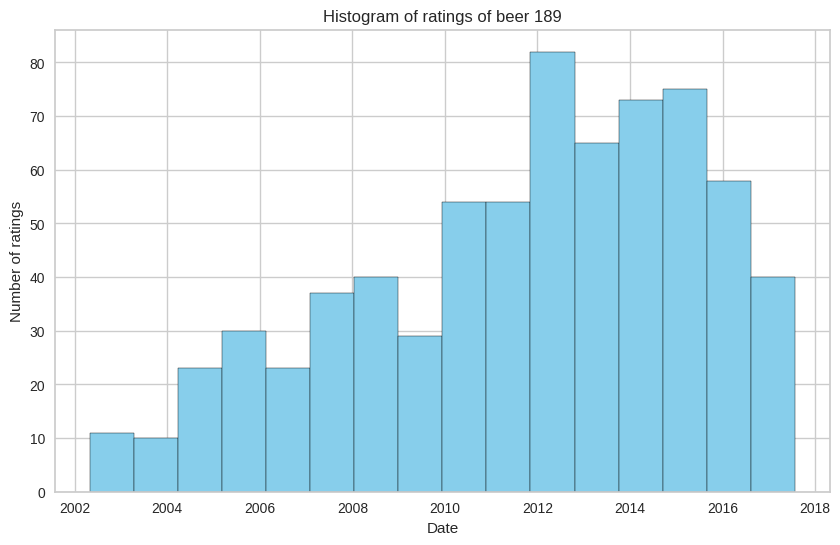

In [ ]:
# Lets first look at the histogram of ratings of a beer, (beer_id=189)
ratings_beer_id_189 = df_ratings_date.loc[df_ratings_date['beer_id']==189]

# Histogram of the number of beer released by date

plt.figure(figsize=(10, 6))
plt.hist(ratings_beer_id_189.date, bins=16,color='skyblue', edgecolor='black')
#plt.yscale('log')

# Adding labels and title
plt.title('Histogram of ratings of beer 189')
plt.xlabel('Date')
plt.ylabel('Number of ratings')


# Show the plot
plt.show()

On this first 'yearly' histogram we clearly see that the maximum number of ratings is obtained in 2004 and that later on the beer is no longer trendy.

In [ ]:
# Creating a df with the rating dates of the "popular beers"
popular_beers_list=df_beers_date_popular.beer_id
popular_beers_df = pd.DataFrame(popular_beers_list)
df_ratings_date_popular=popular_beers_df.merge(df_ratings_date)
display(df_ratings_date_popular)

,beer_id,date
0,189,2017-07-23 10:00:00
1,189,2017-07-20 10:00:00
2,189,2017-07-19 10:00:00
3,189,2017-07-03 10:00:00
4,189,2017-07-02 10:00:00
...,...,...
730697,326774,2017-04-11 10:00:00
730698,326774,2017-04-10 10:00:00
730699,326774,2017-04-09 10:00:00
730700,326774,2017-04-09 10:00:00


We now have the dataframe `df_ratings_date_popular`, it contains all the 'popular' beers that where released in 2002 or afterwards, and that are considered as popular. We will therefore continue the analysis with this df.

As said above, we want the popular beers to have more than 500 ratings which is an interesting threshold. However, it doesn't really reflects the trendiness of a beer, so once we have sorted the beers as being popular, we want to look at the time evolution of this ratings distribution. Therefore if we want to map the trendy peaks we will look at the highest absolute increase of number of ratings from one year to another.

We have selected this second approach as we think it is the most robust metric. It is less sensible than the year with max ratings, or the highest rate increase in ratings.

In [ ]:
def detect_popular_beer(df):
    # Grouping by 'beer_id' and counting the number of ratings for each beer
    beer_ratings_count = df.groupby('beer_id').size().reset_index(name='ratings_count')

    # Filtering beers that attained at least 500 ratings
    popular_beers = beer_ratings_count[beer_ratings_count['ratings_count'] >= 500]

    # Creating an empty dictionary to store beer_id and its time to attain 500 ratings
    time_to_500 = {}

    # Iterating through popular beers to calculate time to 500 ratings for each
    for beer_id in popular_beers['beer_id']:
        ratings_dates = df[df['beer_id'] == beer_id].sort_values(by='date')
        first_500_ratings = ratings_dates.iloc[:500]

        if len(first_500_ratings) >= 500:
            time_to_500[beer_id] = first_500_ratings.iloc[-1]['date'] - first_500_ratings.iloc[0]['date']

    # Finding the year with the highest increase in ratings for each beer
    max_year_increase = {}
    for beer_id in beer_ratings_count['beer_id']:
        beer_ratings = df[df['beer_id'] == beer_id].sort_values(by='date')
        beer_ratings['year'] = beer_ratings['date'].dt.year
        yearly_counts = beer_ratings.groupby('year').size()

        if len(yearly_counts) > 1:
            diff_yearly_counts=yearly_counts.diff()
            increase_yearly_counts=diff_yearly_counts[diff_yearly_counts>0]
            if len(increase_yearly_counts) >1 :
              max_increase = increase_yearly_counts.max()
              max_year = increase_yearly_counts.idxmax()
              max_year_increase[beer_id] = {'year': max_year, 'increase': max_increase}
        else:
              max_increase = np.nan
              max_year = increase_yearly_counts.idxmax()
              max_year_increase[beer_id] = {'year': max_year, 'increase': max_increase}

    return time_to_500, max_year_increase


In [ ]:
time_to_500_ratings, max_year_increase = detect_popular_beer(df_ratings_date_popular)
print("Time to attain 500 ratings for each beer:")
print(time_to_500_ratings)
print("\nYear with the highest increase in ratings for each beer:")
print(max_year_increase)

Time to attain 500 ratings for each beer:
{189: Timedelta('4412 days 00:00:00'), 588: Timedelta('2665 days 23:00:00'), 981: Timedelta('3213 days 00:00:00'), 1211: Timedelta('4148 days 23:00:00'), 1381: Timedelta('4126 days 01:00:00'), 1583: Timedelta('3886 days 01:00:00'), 1629: Timedelta('4514 days 00:00:00'), 1906: Timedelta('4057 days 00:00:00'), 2116: Timedelta('4196 days 23:00:00'), 2488: Timedelta('2399 days 23:00:00'), 2497: Timedelta('1327 days 01:00:00'), 2498: Timedelta('4128 days 01:00:00'), 2513: Timedelta('5634 days 23:00:00'), 4007: Timedelta('4340 days 00:00:00'), 4439: Timedelta('4836 days 23:00:00'), 4611: Timedelta('2064 days 00:00:00'), 4947: Timedelta('4361 days 00:00:00'), 5095: Timedelta('5053 days 00:00:00'), 6076: Timedelta('2949 days 00:00:00'), 6098: Timedelta('3803 days 00:00:00'), 6105: Timedelta('4434 days 00:00:00'), 6161: Timedelta('3987 days 00:00:00'), 6924: Timedelta('4687 days 00:00:00'), 6942: Timedelta('3239 days 00:00:00'), 6950: Timedelta('3441 da

The function above does two things

1.   It measures the time taken to achieve the 500 ratings, that we have defined as being necessary to define a beer as popular
2.   Measure in which year there is the highest (absolute) increase in the number of ratings

The output are given in dictionnaries that we will then reshape in dataframes.

Now lets look at the time to get to 500 ratings, and plot the distribution on the 746 'popular' beers that we have.



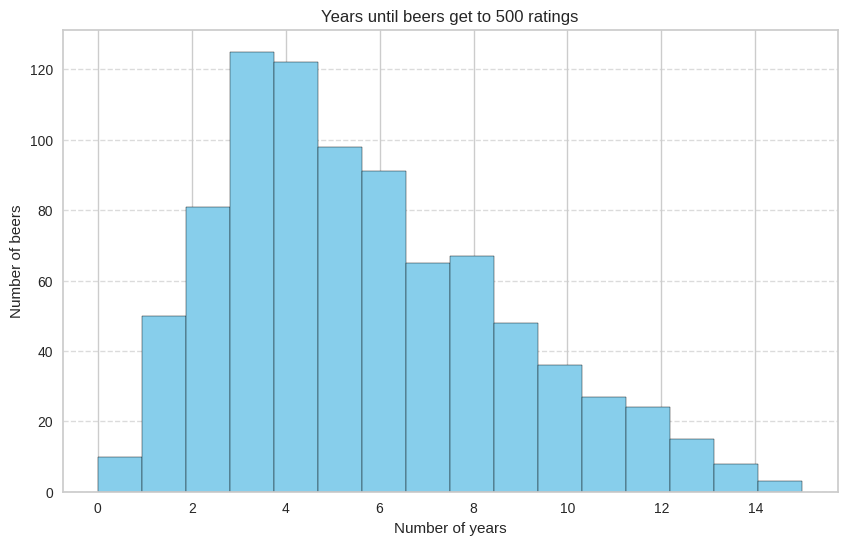

count    870.000000
mean       5.552874
std        3.184591
min        0.000000
25%        3.000000
50%        5.000000
75%        8.000000
max       15.000000
Name: years_to_500, dtype: float64


In [ ]:
# Convert the dictionary into a DataFrame
df_500 = pd.DataFrame.from_dict(time_to_500_ratings, orient='index').reset_index()

# Rename the columns to match the desired structure
df_500.columns = ['beer_id', 'Timedelta']
# Convert Timedelta to years
df_500['years_to_500'] = df_500['Timedelta'].dt.days//365

# Plotting the histogram of counts aggregated by years
plt.figure(figsize=(10, 6))
plt.hist(df_500['years_to_500'], bins=16,color='skyblue',edgecolor='black')
plt.xlabel('Number of years')
plt.ylabel('Number of beers')
plt.title('Years until beers get to 500 ratings')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Quick description of the distribution
print(df_500['years_to_500'].describe())

We can see that the distribution is rightly skewed, with a median at 5, and a mean a litlle bit above at 5.55 years.

In [ ]:
# Now that we have the df_500 lets merge it with df_beers
df_beers_to_500=df_beers_date_popular.merge(df_500.drop(columns=['Timedelta']), how = 'left', on = 'beer_id')


Now lets look at the years with the highest increase.

In [ ]:
# Same method as above to convest dictionnary into df
df_increase = pd.DataFrame.from_dict(max_year_increase, orient='index').reset_index()
df_increase.columns = ['beer_id', 'Peak year', 'Peak ratings']

# Merge it with df_beers so that we both have the release and peak date
df_beers_peak =df_beers_to_500.merge(df_increase, how='right', on='beer_id')
# Add the lag column with the difference between release and peak year
df_beers_peak['lag']=(df_beers_peak['Peak year']-df_beers_peak['release_date'].dt.year)

# And display the added columns
display(df_beers_peak[['years_to_500','lag']])

,years_to_500,lag
0,12,8
1,7,4
2,8,5
3,11,1
4,11,2
...,...,...
741,1,1
742,2,1
743,3,1
744,2,2


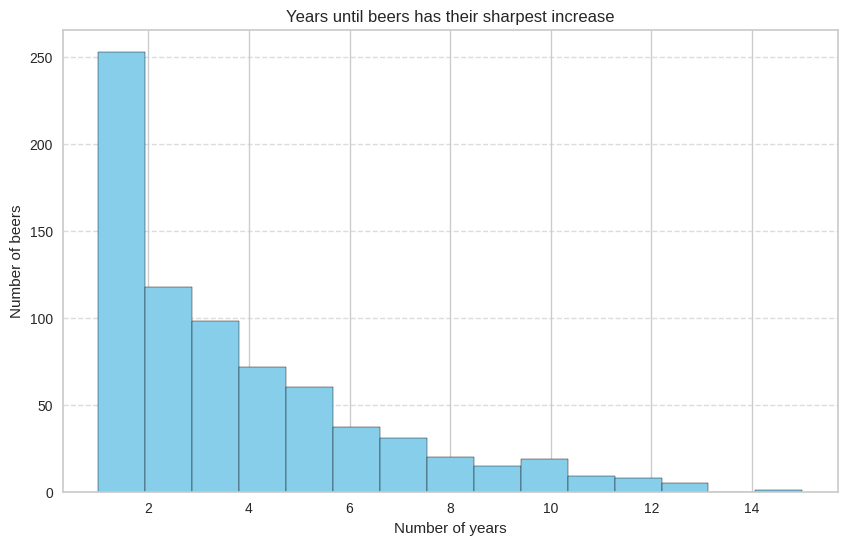

count    746.00000
mean       3.44504
std        2.82896
min        1.00000
25%        1.00000
50%        3.00000
75%        5.00000
max       15.00000
Name: lag, dtype: float64


In [ ]:
# Now lets plot this 'lag'
plt.figure(figsize=(10, 6))
plt.hist(df_beers_peak.lag, bins=15,color='skyblue',edgecolor='black')
plt.xlabel('Number of years')
plt.ylabel('Number of beers')
plt.title('Years until beers has their sharpest increase')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# The quick description
print(df_beers_peak.lag.describe())

With this second method for trend definition, the distribution is also rightly skewed, but the time span are way shorter. With over a third of the beers having the highest ratings absolute increase a year after the release. Now lets compare this two values for each beer (look at the difference between them for all beers).

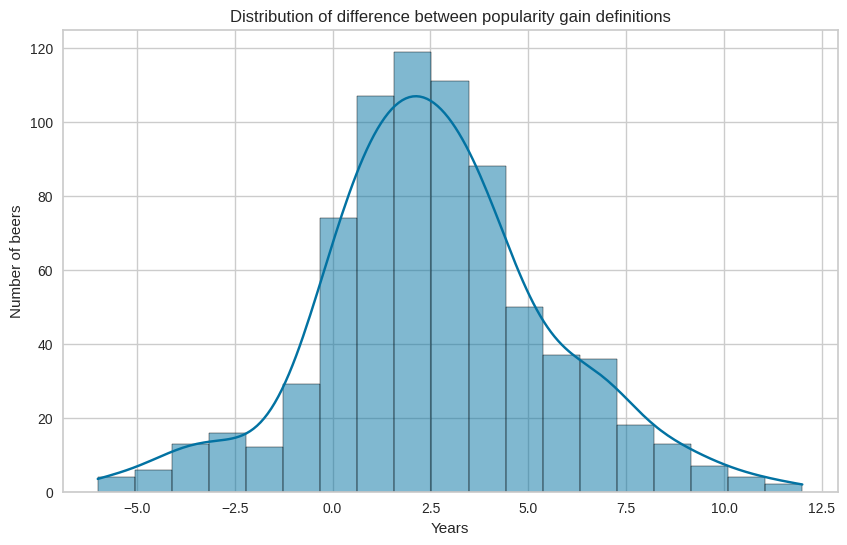

count    746.000000
mean       2.608579
std        2.989850
min       -6.000000
25%        1.000000
50%        2.000000
75%        4.000000
max       12.000000
Name: popularity_time_diff, dtype: float64


In [ ]:
# Create the column 'popularity_time_diff' and plot its distribution
df_beers_peak['popularity_time_diff']=df_beers_peak['years_to_500']-df_beers_peak['lag']

# Now lets do this histogram
plt.figure(figsize=(10, 6))
sns.histplot(df_beers_peak, x='popularity_time_diff', bins=19, kde=True)
#plt.hist(df_beers_peak.popularity_time_diff, color='skyblue', edgecolor='black')

# Adding labels and title
plt.title('Distribution of difference between popularity gain definitions')
plt.xlabel('Years')
plt.ylabel('Number of beers')

# Show the plot
plt.show()

print(df_beers_peak.popularity_time_diff.describe())

From the 'describe' function above, we can see that the average difference between the `years_to_500` and `lag` is 2.6 years. It makes a lot of sense that this average is positive (and relatively large) as the beers that entered the list must only satisfy the 500 ratings, some of them might take a long time to get there.

The maximum difference being 12 years and the minimum -6 years, the distribution plot is done with 19 bins.

The distribution is symmetrical but doesn't look normal, it doesnt look skewed either. So we will perform a Kolmogoriv-Smirnoff test, to assess its kind.
This test takes the Null hypothesis that the distribution given is normal. So if the p-value of the test is smaller than a threshold previously set, we can say that the distibution is not normal.

In addition we will run a skew test, to see if the distribution is symmetrical or skewed. The scipy `sckewtest` has the null hypothesis that the distribution has the same skweness as the normal distribution and so that the distribution is not skewed.

In [ ]:
#perform Kolmogorov-Smirnov test for normality
print(kstest(df_beers_peak.popularity_time_diff, 'norm'))

# Perform skew_test for symmetry
print(skewtest(df_beers_peak.popularity_time_diff))

KstestResult(statistic=0.6349104297146555, pvalue=2.6590212904056568e-292, statistic_location=1, statistic_sign=-1)
SkewtestResult(statistic=1.3471921184930555, pvalue=0.17791836567155195)



The results of the two test are as follows.

1.   As we obtain a very small p-value(almost zero) for Kommogorov Smirnov, we can say with the threshold of 0.5% (which is very conservative) (`p-val<0.005`) that  we reject the null hypothesis and the difference between the popularity estimations is not a normal distribution.
2.   The second test yields to `p-val=0.18`, so that we canno't reject the null hypothesis (even with a 5% threshold), so the distribution is symmetric.


Now that we know that the distribution of the difference is not normal but still symmetric, lets look at the average of the two metrics (for each beer) and use it for the further analysis.

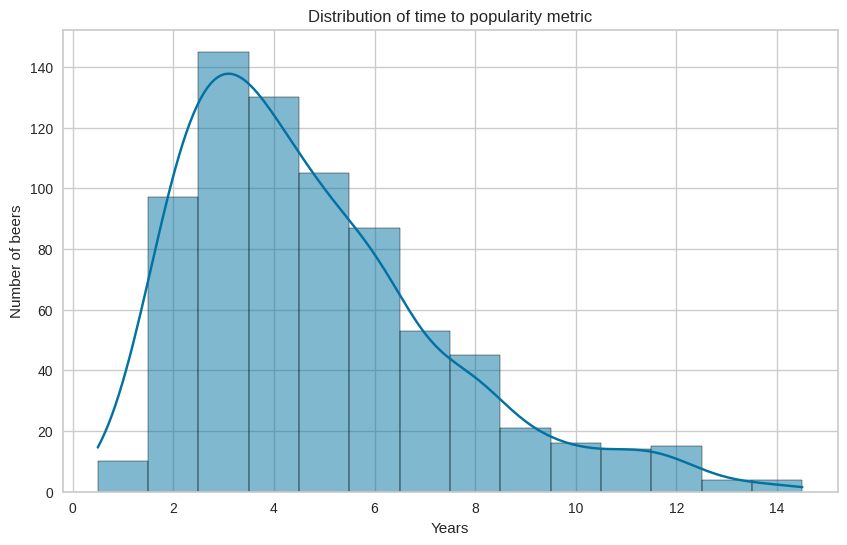

count    746.000000
mean       4.749330
std        2.566465
min        0.500000
25%        3.000000
50%        4.000000
75%        6.000000
max       14.500000
Name: average_pop_metrics, dtype: float64


In [ ]:
df_beers_peak['average_pop_metrics']=(df_beers_peak['years_to_500']+df_beers_peak['lag'])/2
# Now lets do this histogram
plt.figure(figsize=(10, 6))
sns.histplot(df_beers_peak, x='average_pop_metrics', bins=14, kde=True)
#plt.hist(df_beers_peak.popularity_time_diff, color='skyblue', edgecolor='black')

# Adding labels and title
plt.title('Distribution of time to popularity metric')
plt.xlabel('Years')
plt.ylabel('Number of beers')
# Show the plot
plt.show()

print(df_beers_peak.average_pop_metrics.describe())

The distribution of the average of the two measurement for popularity gain is also a right skew. Its median (more usefull than the mean for skewed data) is at 4 years. Which means that half of the beers take 4 years to gain popularity.

### Influence on popularity gain
Now that we have computed the time delay to reach popularity for 746 beers, we would like  to try to look at what could explain it.

Our first idea is to look at the popularity of the breweries that produce those beers, to do so we will look at the biggest breweries worldwide on the webnumber of appearance in the popular beers list. We will the look at their time distribution and run some statistical tests.

In [ ]:
# Take the df_beers_peak and apply groupby 'brewery_id'
breweries_pop_beers=df_beers_peak.groupby(by='brewery_id').size()
# Creating a df out of this
df_breweries_pop_beers=pd.DataFrame(breweries_pop_beers)
df_breweries_pop_beers.columns=['popular_beers']
# Showing some data about it
display(df_breweries_pop_beers.sort_values(by=['popular_beers'], ascending=False))
print(df_breweries_pop_beers.describe())

,popular_beers
brewery_id,
7043,22
3473,16
3642,15
4923,12
292,12
...,...
1068,1
1100,1
1189,1


       popular_beers
count     254.000000
mean        2.937008
std         3.102334
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        22.000000


When grouping the popular beers by there brewery, we see that half of the breweries have 2 beers, and the brewery with more appearances has 22 beers. We will define the big breweries as the breweries with 10 beers or more.


In [ ]:
# Application of the '10 popular beers' filter
df_breweries_pop=df_breweries_pop_beers.loc[df_breweries_pop_beers['popular_beers']>=10]
display(df_breweries_pop)
print('There are',len(df_breweries_pop),"'famous' breweries.")

# Merging it back into the df_beers
df_beers_breweries = df_beers_peak.merge(df_breweries_pop_beers, how='left', on = 'brewery_id')
display(df_beers_breweries)

,popular_beers
brewery_id,
22,11
109,10
292,12
364,10
398,10
432,11
1167,11
1889,11
3111,10


There are 16 'famous' breweries.


,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,overall_score,style_score,avg,abv,...,avg_matched_valid_ratings,earliest_rating,release_date,years_to_500,Peak year,Peak ratings,lag,popularity_time_diff,average_pop_metrics,popular_beers
0,189,Stiegl Goldbräu,39,Stieglbrauerei zu Salzburg,Premium Lager,704,16.0,48.0,2.70,4.9,...,2.708523,1020333600,2002-05-02 10:00:00,12,2010,28.0,8,4,10.0,1
1,588,Rogue Irish Style Lager,96,Rogue Ales,Premium Lager,705,36.0,77.0,3.00,5.0,...,2.999149,1014030000,2002-02-18 11:00:00,7,2006,112.0,4,3,5.5,8
2,981,Lakefront Fuel Cafe,156,Lakefront Brewery,Sweet Stout,762,44.0,21.0,3.12,6.4,...,NaN,1013598000,2002-02-13 11:00:00,8,2007,66.0,5,3,6.5,2
3,1211,Orkney Dragonhead (Bottle),203,Orkney (Sinclair Breweries),Stout,572,70.0,54.0,3.34,4.0,...,NaN,1040986800,2002-12-27 11:00:00,11,2003,48.0,1,10,6.0,1
4,1381,vyturys Ekstra,188,vyturys (Carlsberg),Dortmunder/Helles,624,10.0,10.0,2.51,5.2,...,NaN,1026986400,2002-07-18 10:00:00,11,2004,53.0,2,9,6.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
741,215531,Prairie Bomb!,1908,Krebs Brewing Company / Petes Place / Choc Beer,Imperial Stout,1111,100.0,99.0,4.14,13.0,...,NaN,1370167200,2013-06-02 10:00:00,1,2014,160.0,1,0,1.0,2
742,216961,To Øl Black Malts & Body Salts Black Coffee IIPA,12119,To Øl,Black IPA,683,100.0,100.0,4.03,9.9,...,NaN,1371808800,2013-06-21 10:00:00,2,2014,70.0,1,1,1.5,2
743,230018,Beavertown Neck Oil (2013- ),14320,Beavertown Brewery,Session IPA,516,90.0,93.0,3.54,4.3,...,NaN,1380621600,2013-10-01 10:00:00,3,2014,147.0,1,2,2.0,4
744,241569,Spencer Trappist Ale,18289,Spencer Brewery,Belgian Ale,647,89.0,96.0,3.53,6.5,...,NaN,1388833200,2014-01-04 11:00:00,2,2016,90.0,2,0,2.0,1


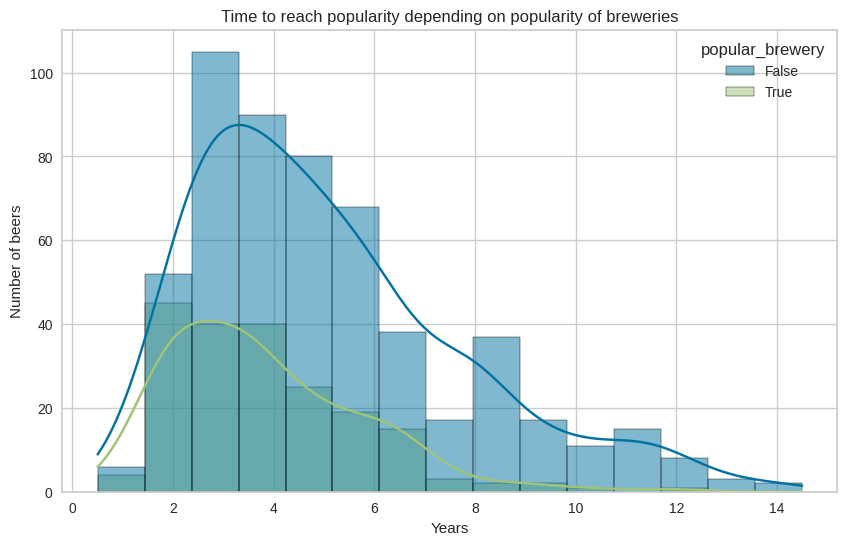

In [ ]:
# Creating a 'popular_brewery' column
df_beers_breweries['popular_brewery']=df_beers_breweries['popular_beers']>=10

# Plotting the histogram of average_pop_metrics depending on brewery popularity
plt.figure(figsize=(10, 6))
sns.histplot(df_beers_breweries, x='average_pop_metrics', hue='popular_brewery', bins=15, kde=True)
plt.title('Time to reach popularity depending on popularity of breweries')
plt.xlabel('Years')
plt.ylabel('Number of beers')
plt.savefig('fig_q3_3.jpg')
plt.show()


From the above plot, we cannot see a major difference between the two distributions. The 'famous breweries' group, doesn't seem to go over 10 years before reaching popularity whereas some other (non famous) go up to 14 years. However this visual plot, is less precise than statistical methods that we will implement later.

Now another clue that we could try to explore is the location of the brewery. As it will be further explained later (Research question 4), most of the users of the website are located in the U.S, and  RateBeer collects a lot of craft beers that might not be exported everywhere. So lets see if the origin of the beer has an influence on its popularity gain.



True     442
False    304
Name: is_us, dtype: int64


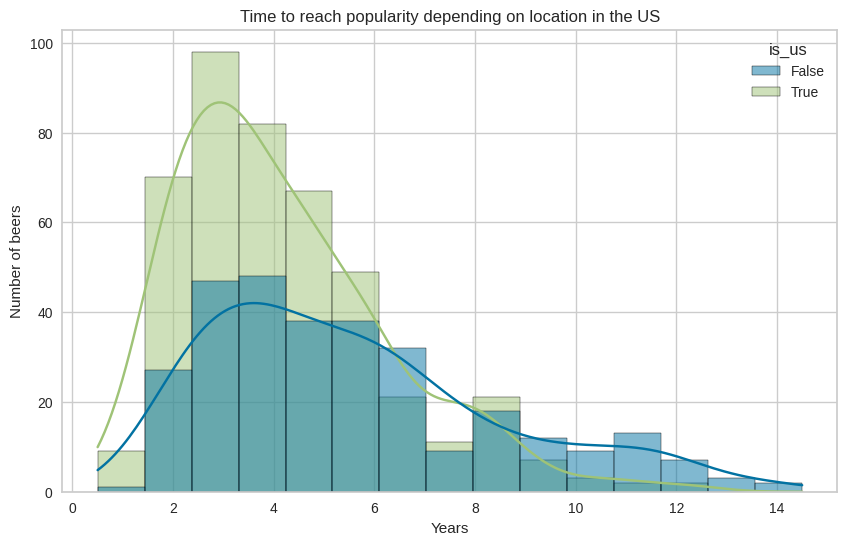

In [ ]:
# As we don't have the brewery location data on our df_beers,
# we merge it with df_breweries and we have to replace the name
df_breweries=df_breweries.rename(columns={'id':'brewery_id'})
df_beers_breweries_location=df_beers_breweries.merge(df_breweries, how='left', on='brewery_id')

# We now create a new column 'is_us' with True if the location contains
#'United States' and  otherwise
df_beers_breweries_location['is_us']=df_beers_breweries_location.location.str.contains('United States')
print(df_beers_breweries_location.is_us.value_counts())

# Finally lets plot the distributions
# Plotting the histogram of average_pop_metrics depending on brewery popularity
plt.figure(figsize=(10, 6))
sns.histplot(df_beers_breweries_location, x='average_pop_metrics', hue='is_us', bins=15, kde=True)
plt.title('Time to reach popularity depending on location in the US')
plt.xlabel('Years')
plt.ylabel('Number of beers')
plt.show()

We can see that more than half of the beers are crafted in the US, most of the beers having an early popularity are american, while the late popular ones are not. This plot shows that the US location seems to have a big impact.

Finally lest look at styles :

In [ ]:
# Looking at the styles appearing more in our df_beers
print(df_beers_breweries_location['style'].value_counts())

# Taking the most recurrant styles
onehot_tracks = pd.get_dummies(df_beers_breweries_location['style'])
onehot_tracks=onehot_tracks.drop(columns=['Abbey Dubbel', 'Abbey Tripel', 'Abt/Quadrupel', 'Altbier', 'Amber Ale',
       'Amber Lager/Vienna', 'American Pale Ale', 'American Strong Ale ',
       'Baltic Porter', 'Barley Wine', 'Belgian Ale',
       'Berliner Weisse', 'Bitter', 'Bière de Garde', 'Black IPA', 'Brown Ale',
       'Cream Ale', 'Czech Pilsner (Světlý)', 'Doppelbock',
       'Dortmunder/Helles', 'Dry Stout', 'Dunkel/Tmavý', 'Dunkler Bock',
       'Eisbock', 'English Pale Ale', 'English Strong Ale', 'Foreign Stout',
       'Fruit Beer', 'German Hefeweizen', 'Golden Ale/Blond Ale',
       'Grodziskie/Gose/Lichtenhainer',
       'Imperial Pils/Strong Pale Lager', 'Imperial Porter',
        'India Style Lager', 'Kölsch',
       'Lambic Style - Faro', 'Lambic Style - Fruit', 'Lambic Style - Gueuze',
       'Lambic Style - Unblended', 'Oktoberfest/Märzen', 'Old Ale',
       'Pale Lager', 'Pilsener', 'Porter', 'Premium Bitter/ESB',
       'Premium Lager', 'Radler/Shandy', 'Saison', 'Schwarzbier', 'Scotch Ale',
       'Scottish Ale', 'Session IPA', 'Smoked', 'Sour Red/Brown',
       'Sour/Wild Ale', 'Specialty Grain', 'Spice/Herb/Vegetable', 'Stout',
       'Sweet Stout', 'Traditional Ale', 'Weizen Bock', 'Wheat Ale', 'Witbier',
       'Zwickel/Keller/Landbier'])
df_beers_breweries_location = pd.concat([df_beers_breweries_location, onehot_tracks], axis=1)

Imperial Stout                     80
India Pale Ale (IPA)               70
Imperial IPA                       62
Belgian Strong Ale                 49
Saison                             35
                                   ..
Czech Pilsner (Světlý)              1
Lambic Style - Faro                 1
India Style Lager                   1
Kölsch                              1
Imperial Pils/Strong Pale Lager     1
Name: style, Length: 68, dtype: int64


True     442
False    304
Name: is_us, dtype: int64


<ipython-input-73-ca0fdac7927e>:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_beers_breweries_location['popular_style']=df_beers_breweries_location['style'].str.contains('Imperial Stout|India Pale Ale (IPA)|Imperial IPA|Belgian Strong Ale')


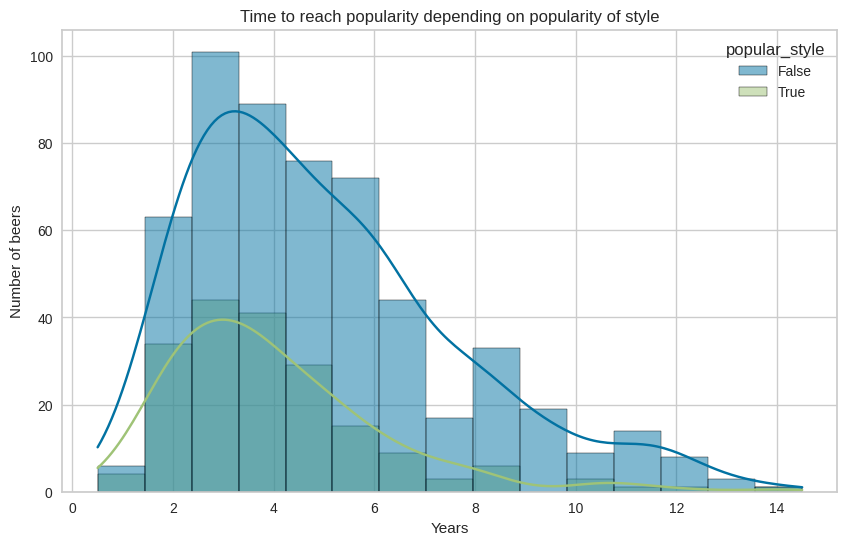

In [ ]:
# We now create a new column 'is_us' with True if the location contains
#'United States' and  otherwise
df_beers_breweries_location['popular_style']=df_beers_breweries_location['style'].str.contains('Imperial Stout|India Pale Ale (IPA)|Imperial IPA|Belgian Strong Ale')
print(df_beers_breweries_location.is_us.value_counts())

# Finally lets plot the distributions
# Plotting the histogram of average_pop_metrics depending on brewery popularity
plt.figure(figsize=(10, 6))
sns.histplot(df_beers_breweries_location, x='average_pop_metrics', hue='popular_style', bins=15, kde=True)
plt.title('Time to reach popularity depending on popularity of style')
plt.xlabel('Years')
plt.ylabel('Number of beers')
plt.savefig('fig_q3_4.jpg')
plt.show()

On this last example, with only one beer style that represents only 10% of the beers the plot is not usefull even though there might be a relation.

Now instead of going predictor by predictor and looking visually at the impact on the distributions, lets run a linear regression. In this regression the dependent variable is the lag time to popularity(we will choose the `average_pop_metrics`), and the predictors are the usefull columns of df_beers such as :
 `popular_brewery`, `style

*   Location (to investigate if the US have an impact)
*   `popular_brewery`
*   `popular style`
*   `overall_score`
*   etc






In [ ]:
# Preparing the dataframe for regressions
df_beers_3_reg = df_beers_breweries_location.copy(deep=True)
# Re-scale overall_score from score/100 to score/10
df_beers_3_reg['overall_score']=df_beers_3_reg.overall_score/10

In [ ]:
# Regression 1: average_pop_metrics ~ overall_score, popular_brewery, location_us, abv
model_1 = smf.ols(formula='average_pop_metrics ~ popular_brewery', data=df_beers_3_reg).fit()
print("Regression 1:")
print(model_1.summary())

# Regression 2: average_pop_metrics ~ is_us
model_2 = smf.ols(formula='average_pop_metrics ~ is_us', data=df_beers_3_reg).fit()
print("Regression 2:")
print(model_2.summary())

# Regression 3: average_pop_metrics ~ style
df_reg3x=df_beers_3_reg[['Belgian Strong Ale', 'Imperial IPA', 'Imperial Stout','India Pale Ale (IPA)']]
df_reg3y=df_beers_3_reg['average_pop_metrics']
df_reg3x=sm.add_constant(df_reg3x)

model_3 = sm.OLS(df_reg3y, df_reg3x).fit()
print("Regression 3:")
print(model_3.summary())

# Regression 4: average_pop_metrics ~ overall_score
model_4 = smf.ols(formula='average_pop_metrics ~ overall_score', data=df_beers_3_reg).fit()
print("Regression 4:")
print(model_4.summary())

Regression 1:
                             OLS Regression Results                            
Dep. Variable:     average_pop_metrics   R-squared:                       0.047
Model:                             OLS   Adj. R-squared:                  0.046
Method:                  Least Squares   F-statistic:                     37.01
Date:                 Fri, 22 Dec 2023   Prob (F-statistic):           1.88e-09
Time:                         22:04:38   Log-Likelihood:                -1743.0
No. Observations:                  746   AIC:                             3490.
Df Residuals:                      744   BIC:                             3499.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
In

To analyze a linear regression we need to look at the `p-value` and `coef`of the predictor, the`R-squared`of the model. The `p-value`associated to the predictor tests the hypothesis that the predictor has no impact on the dependent variable, the `coef` gives the magnitude and direction of the impact of the increase in 1 in the preditcor value and the `R²`estimates how well this model explains the variance on the dependent variable. In our examples the dependent variable is the `average_pop_metrics`which is a measure in years of the time that the beer takes to get popular. Therefore a popular beer has a small value in this parameter (we will use a 5% threshold). The predictors are either binary or continious values.


1.   `p-val=0.000`, `coef=-1.27`and `R²=0.047`as the p-value goes to zero we reject the null hypothesis, and the popularity of the beer is statistically significant on its popularity gain. The coef implies that a beer coming from a popular brewery would take 1.26 years less to reach popularity. Vor the variance, only a small fraction of it is explained by this predictor.
2.   `p-val=0.000`, `coef=-1.41`and `R²=0.073` here again the predictor is statistically significant. The coefficient implies that if the beer comes from the US, it will take 1.41 years less to become popular. A bit more variance is explained but this is still (very) low compared to the maximum possible value (1).

3.  For the styles, we picked the four that appeared the most, so we have four predictors. Two of them are not statistically significant (`p-val>0.05) (Belgian Strong Ale and Indian Pale Ale), the other two have an impact, and it is quite large. For the Imperial Stout, the coefficient implies that if a beer is of that style, it will take 1.22 years less to reach popularity and similarly for the Imperial IPA (with 1.03 years).
Here again the variance of `average_pop_metrics` is poorly explained by the model.

4.  `p-val=0.000`, `coef=-0.29`and `R²=0.071` the overall score (that we have rescaled a bit) implies that if we increase the score from 1/10, we decrease the lag time of 0.29 years. this is not the stongest impact we have seen.


In conclusion, we can say that popular beers take around 4 years to reach popularity. The profile of beer that would reach popularity the fastest would come from an american brewery, that has many other popular beers, having a good overall_score and from a precise popular style (tipically Imperial Stout or Imperial IPA).
All these parameters appear on the website, such that we could hypothesize that trendy beers are highlighted on RateBeer, which feeds the trend.

# Research question 4


## Preliminary study

We will now analyze the evolution of beer preferences in different regions of the world and see whether we can see some differences between countries/continents. We will separate the analysis of single beers from the analysis of beer styles

Each user has an associate country an the users dataframe. Let's first quickly see where do users come from and check the missing percentage of location data.

In [ ]:
unique_locations_count = df_users['location'].nunique()
print("Number of different locations for users:", unique_locations_count)

Number of different locations for users: 222


In [ ]:
missing_location_count = (df_users['location'].isnull().sum()/len(df_users)) * 100
print(f'the missing percentage of the location data is {missing_location_count}%')

the missing percentage of the location data is 27.90492205090204%


As we can see almost 30% of the location data is missing from the users. As this data is fundamental let's remove all the users that don't have a location associated

In [ ]:
df_users_loc = df_users.copy()
df_users_loc = df_users[df_users['location'].notna()]

We will be working on the ratings file. We will not be studying the text so we will delete it. The taste, palatte and aroma We also transform the unix time into regulare dates. Finally we merge the ratings with the users data, performing an inner merge with users whose location is provided (df_users_loc) in order to keep only the data where we have the user's location.

In [ ]:
df_ratings_loc = df_ratings.copy()
columns_to_drop = ['appearance', 'aroma', 'palate', 'taste', 'text']
df_ratings_loc.drop(columns = columns_to_drop,inplace=True)
df_ratings_loc['date'] = pd.to_datetime(df_ratings_loc['date'], unit='s')
df_ratings_loc = pd.merge(df_ratings_loc, df_users_loc[['user_id', 'location']], on='user_id', how='inner')
print(f'There is {len(df_ratings_loc)/len(df_ratings)*100} % of reviews left ')

There is 97.16393005745236 % of reviews left 


As can be seen we still have a lot of data left. This is probabaly due to the the fact that users who don't specify their location don't do lots of reviews

Let's now see what are the main countries of the users in the ratings dataframe. We do this with value count, we additionnally plot a histogram of the number of ratings for each country. For clarity issues, and given this is only for visualization, we remove the names of the countries

Denmark                      581975
Canada                       522693
England                      440846
United States, California    315108
Sweden                       283459
                              ...  
Papua New Guinea                  1
Ivory Coast                       1
Burundi                           1
Antigua and Barbuda               1
Tibet                             1
Name: location, Length: 222, dtype: int64


Text(0.5, 0, 'Country')

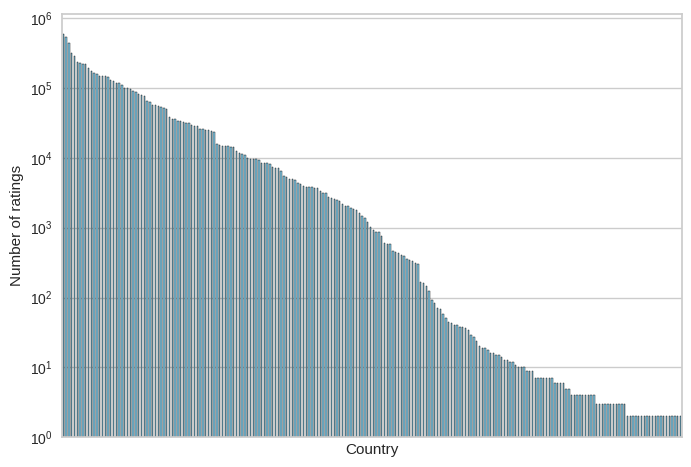

In [ ]:
value_counts = df_ratings_loc['location'].value_counts()
print(value_counts)
# plt.bar(value_counts.index, value_counts, color='skyblue', edgecolor='black')
value_counts.plot(kind='bar', color='skyblue', edgecolor='black',log=True)
plt.xticks([])
plt.ylabel('Number of ratings')
plt.xlabel('Country')

We can see that there are many countries with a lot of ratings. To get an idea if there might be differences between various countries regions let's first print the distribution of ratings for the top 9 regions.

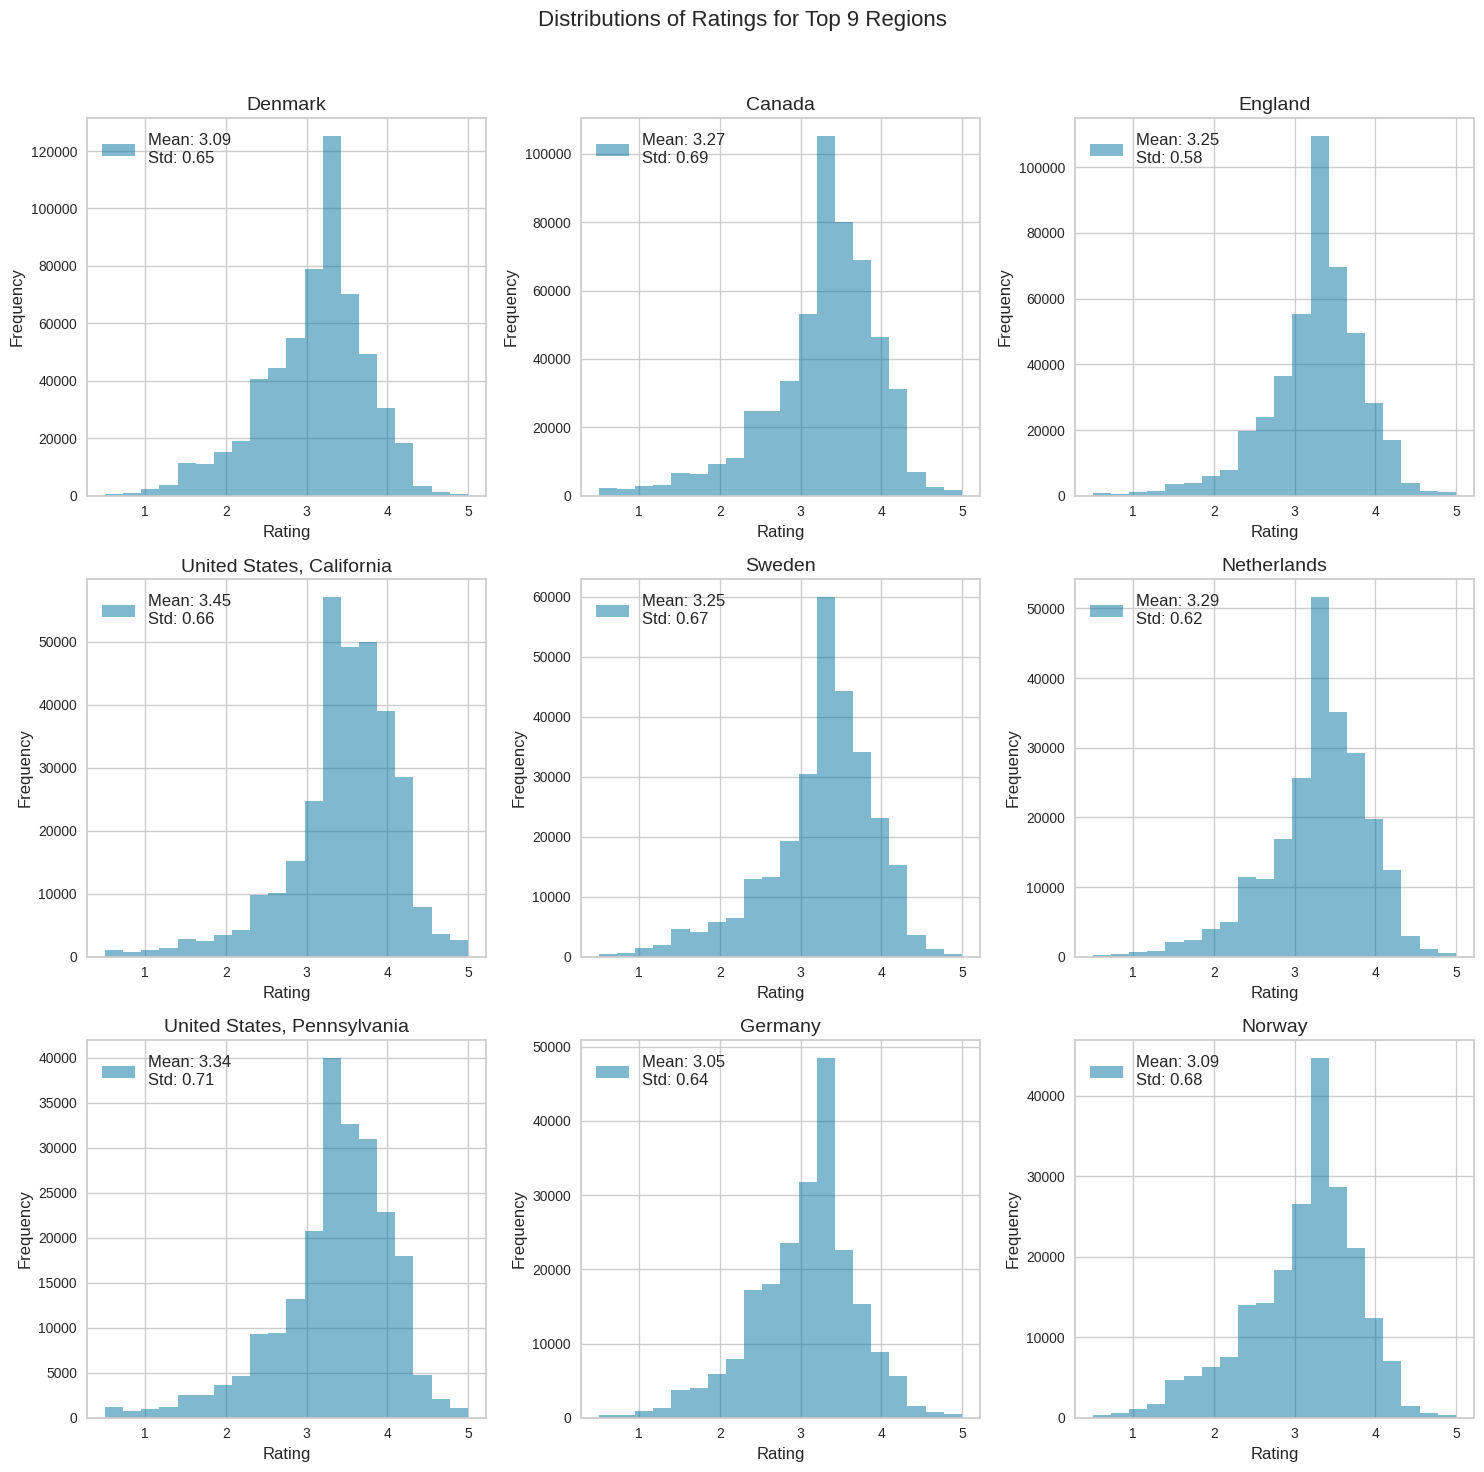

In [ ]:
# Get the top 9 regions by rating count
top_regions = df_ratings_loc['location'].value_counts().nlargest(9).index

# Filter the DataFrame to include only the top 9 regions
df_top_regions = df_ratings_loc[df_ratings_loc['location'].isin(top_regions)]

# Create subplots (3x3 layout)
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Distributions of Ratings for Top 9 Regions', fontsize=16)

# Plot each distribution on a separate subplot
for i, region in enumerate(top_regions):
    ax = axes[i // 3, i % 3]
    ratings = df_top_regions[df_top_regions['location'] == region]['rating']
    ax.hist(ratings, bins=20, alpha=0.5)
    # Calculate mean and standard deviation
    mean_value = ratings.mean()
    std_value = ratings.std()

    # Add mean and std to the legend
    ax.legend([f'Mean: {mean_value:.2f}\nStd: {std_value:.2f}'],fontsize=12)

    ax.set_title(region,fontsize=14)
    ax.set_xlabel('Rating',fontsize=12)
    ax.set_ylabel('Frequency',fontsize=12)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

It would seem that there are some differences already in the average ratings given in these countries. For example in california the mean rating is 3.45 while in Germany it is 3.05. This is quite significant, to see this better let's plot the distribution of the average ratings for countries with more than 10000 ratings



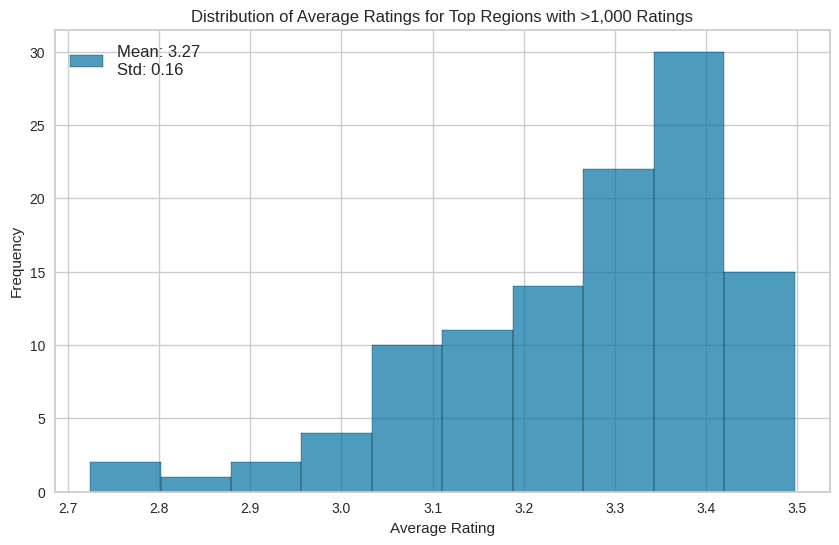

In [ ]:
# Count the number of ratings for each region
ratings_count = df_ratings_loc['location'].value_counts()

# Filter regions with more than 1,000 ratings
top_regions = ratings_count[ratings_count > 1000].index

# Filter the DataFrame to include only the top regions
df_top_regions = df_ratings_loc[df_ratings_loc['location'].isin(top_regions)]

# Calculate the average rating for each region
average_ratings = df_top_regions.groupby('location')['rating'].mean()

# Plot the histogram of average ratings
plt.figure(figsize=(10, 6))
plt.hist(average_ratings, bins=10, edgecolor='black', alpha=0.7)
mean_value = average_ratings.mean()
std_value = average_ratings.std()

# Add mean and std to the legend
plt.legend([f'Mean: {mean_value:.2f}\nStd: {std_value:.2f}'],fontsize=12)
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Average Ratings for Top Regions with >1,000 Ratings')

plt.show()


The standard deviation is of 0.17 and we can see countries with averages below 2.8 and some above 3.4. This is interesting because it already shows that there are some differences between countries/regions in how they grade their beers.
This is significant, therefore we should prioritzie relative comparisons rather than focusing on absolute values. Another possibility is to normalize the data. As we don't necessarily need to compare the absolute values but rather the trends, we choose to work with relative values such as the percentage of increase of the number of ratings or the percentage of increase of the ratings of a beer with respect to previous years.

Now that we have some initial information on the distribution of ratings we can begin to analyze the regions more precisely and find their preferred beer styles.
 As we do not have our beer styles yet in our ratings dataframe we merge the data with the beers datafram on beer id. We perform an inner merge to keep only the beers that have an associated beer style.

In [ ]:
df_ratings_loc_style = df_ratings_loc.copy()
df_ratings_loc_style = pd.merge(df_ratings_loc, df_beers[['beer_id', 'style']], on='beer_id', how='inner')
del df_ratings_loc

# Most popular beer styles
Let's first loook at popularity, where popularity is defined by the number of ratings. Let's check the most popular beer styles for the 10 countries with the most ratings

In [ ]:
# Get the top 10 countries by rating count
top_countries = df_ratings_loc_style['location'].value_counts().nlargest(10).index

# Filter the DataFrame to include only the top 10 countries
df_top_countries = df_ratings_loc_style[df_ratings_loc_style['location'].isin(top_countries)]

# Find the most popular beer style for each country
most_popular_style = df_top_countries.groupby('location')['style'].agg(lambda x: x.mode().iat[0])

# Display the results
print("Most Popular Beer Style:")
print(most_popular_style)

Most Popular Beer Style:
location
Canada                         India Pale Ale (IPA)
Denmark                        India Pale Ale (IPA)
England                                      Bitter
Finland                        India Pale Ale (IPA)
Germany                                    Pilsener
Netherlands                             Belgian Ale
Norway                         India Pale Ale (IPA)
Sweden                         India Pale Ale (IPA)
United States, California      India Pale Ale (IPA)
United States, Pennsylvania    India Pale Ale (IPA)
Name: style, dtype: object


We can see that for 7 out of 10 the most popular beer styles is the IPA. Let's see the list of the most popular beer style for each country and specifically see how many of them have IPA as the most popular

We arbitrarily choose to study only the countries with more than 10 ratings. We compare this to the same result for countries with more than 10000 ratings

In [ ]:
# Filter regions with more than 10 ratings
top_regions10 = ratings_count[ratings_count > 10].index

# Filter regions with more than 10,000 ratings
top_regions10000 = ratings_count[ratings_count > 10000].index

# Filter the DataFrame to include only the top 10 countries
df_top_regions10 = df_ratings_loc_style[df_ratings_loc_style['location'].isin(top_regions10)]
df_top_regions10000 = df_ratings_loc_style[df_ratings_loc_style['location'].isin(top_regions10000)]

# Find the most popular beer style for each country
most_popular_style_10 = df_top_regions10.groupby('location')['style'].agg(lambda x: x.mode().iat[0])
print('The most popular beer styles for countries above 10 ratings')
print(most_popular_style_10.value_counts())
most_popular_style_10000 = df_top_regions10000.groupby('location')['style'].agg(lambda x: x.mode().iat[0])
print('The most popular beer styles for countries above 10000 ratings')
most_popular_style_10000.value_counts()

The most popular beer styles for countries above 10 ratings
India Pale Ale (IPA)      80
Pale Lager                58
Belgian Ale                4
Imperial Stout             4
Bitter                     3
Belgian Strong Ale         2
Czech Pilsner (Světlý)     2
Golden Ale/Blond Ale       2
German Hefeweizen          1
Premium Bitter/ESB         1
Abt/Quadrupel              1
Pilsener                   1
Baltic Porter              1
Fruit Beer                 1
Abbey Dubbel               1
Name: style, dtype: int64
The most popular beer styles for countries above 10000 ratings


India Pale Ale (IPA)      56
Pale Lager                 4
Belgian Ale                2
Czech Pilsner (Světlý)     1
Bitter                     1
Pilsener                   1
Golden Ale/Blond Ale       1
Name: style, dtype: int64

This is intereseting, it shows that first there are two most popular beer styles. The IPA is the most popular and the Pale Lager is the second most popular. There are then some weird countries who have another preferre beer style but there are much less of those. Furthermore we can see that the more countries we include in our list (with a lower amount of ratings) the more the Pale Lager becomes the most popular beer style. Let's see if this bias is caused by the fact that lots of the data comes from US states which are separated into different regions in the location column.
Let's see what the preferred beer styles are for the US states

In [ ]:
# Remove rows where the location is a U.S. state
top_regions_us = ratings_count.index
top_regions_us = top_regions_us[top_regions_us.str.contains('United States')]

# Filter the DataFrame to include only the top 10 countries
df_top_regions_us = df_ratings_loc_style[df_ratings_loc_style['location'].isin(top_regions_us)]

# Find the most popular beer style for each country
most_popular_style_us = df_top_regions_us.groupby('location')['style'].agg(lambda x: x.mode().iat[0])
print('The most popular beer styles for US states are')
print(most_popular_style_us.value_counts())

The most popular beer styles for US states are
India Pale Ale (IPA)    45
Pale Lager               5
Name: style, dtype: int64


Great! This shows that in the US the proportion of states whose most rated style is the IPA is much larger than in other regions. This also shows that it might be difficult to analyze preferences within the US because they seem to be similar, at least from this metric.
We will therefore group countries into larger regions. For this we use a csv file downloaded from the interent containing all the countries in the world and their associated continent (region) as well as subregion. Let's keep only the necessary columns (country, region, subregion)

In [ ]:
country_data = pd.read_csv(path+'/list-of-countries-by-continent-2023.csv')
columns = ['country','region','subregion']
country_data = country_data[columns]
display(country_data)

,country,region,subregion
0,India,Asia,"Southern Asia, South Central Asia"
1,China,Asia,Eastern Asia
2,United States,North America,Northern America
3,Indonesia,Asia,South-Eastern Asia
4,Pakistan,Asia,"Southern Asia, South Central Asia"
...,...,...,...
229,Montserrat,North America,Caribbean
230,Falkland Islands,South America,"South America, Latin America"
231,Niue,Oceania,Polynesia
232,Tokelau,Oceania,Polynesia


Let's now merge with our initial dataframe adding the region and subregion. For US states we merge them all into a single country of United States, region North America, subregion Northern America.

In [ ]:
# Create a mask to identify U.S. states
us_states_mask = df_ratings_loc_style['location'].str.contains('United States')

# Create df_merged dataframe
df_merged = df_ratings_loc_style.copy()

# Assign values for U.S. states
df_merged['country'] = df_merged['location']
df_merged['country'] = np.where(us_states_mask, 'United States', df_merged['country'])

# Drop location, repeated in country, removing US States
df_merged.drop(columns=['location'],inplace=True)

# Get the regions and subregions from the country_data dataframe
df_merged = df_merged.merge(country_data, left_on='country', right_on='country', how='left')

# Display the updated DataFrame
display(df_merged)

,beer_id,brewery_id,date,user_id,overall,rating,style,country,region,subregion
0,410549,3198,2016-04-26 10:00:00,175852,8,2.0,Pale Lager,Poland,Europe,Eastern Europe
1,105273,3198,2015-05-05 10:00:00,175852,6,1.7,Pale Lager,Poland,Europe,Eastern Europe
2,105273,3198,2017-02-17 11:00:00,442761,8,1.9,Pale Lager,Spain,Europe,Southern Europe
3,105273,3198,2016-06-24 10:00:00,288889,5,1.6,Pale Lager,Poland,Europe,Eastern Europe
4,105273,3198,2016-01-01 11:00:00,250510,5,1.5,Pale Lager,Spain,Europe,Southern Europe
...,...,...,...,...,...,...,...,...,...,...
6920082,413789,26941,2016-07-08 10:00:00,419525,16,4.0,Golden Ale/Blond Ale,France,Europe,Western Europe
6920083,226760,16438,2013-09-09 10:00:00,278549,16,4.0,Bière de Garde,France,Europe,Western Europe
6920084,450183,6483,2016-09-17 10:00:00,418646,8,1.9,Mild Ale,France,Europe,Western Europe
6920085,131023,8999,2010-09-24 10:00:00,114143,16,4.0,Doppelbock,Slovak Republic,NaN,NaN


We can see that some countries don't get matched like the Slovak Republic (Slovakia in countries dataframe), let's find how many to see if we can deal with this manually

In [ ]:
# Count the number of countries for which 'region' is NaN
nan_region_count = df_merged[df_merged['region'].isna()]['country'].nunique()
# Get the list of countries for which 'region' is NaN
nan_region_countries = df_merged[df_merged['region'].isna()]['country'].unique()

# Display the result
print(f'Countries with NaN region: {nan_region_countries}')

# Display the result
print(f'Number of countries with NaN region: {nan_region_count}')

Countries with NaN region: ['Scotland' 'Northern Ireland' 'England' 'Slovak Republic' 'Wales'
 'Ascension Island' 'Macedonia' 'Saint Helena' 'Norfolk Island' 'Kosovo'
 'Virgin Islands (U.S.)' 'Saint Vincent and The Grenadines' 'Tibet'
 'Dem Rep of Congo' 'East Timor' 'Fiji Islands' 'Virgin Islands (British)'
 'Abkhazia' 'Hawaii' 'Nagorno-Karabakh']
Number of countries with NaN region: 20


There are 20 which is a lot to deal by hand. We don't want to delete all those rows however because we have regions such as Scotland, Northern Ireland which are part of Great Britain or Slovak Republic that are important if we want to analyze Europe. Nevertheless most of them are very small and have very few ratings. Let's see which of those places has more than 100 ratings

In [ ]:
filtered_countries = df_merged[df_merged['region'].isna()].groupby('country').filter(lambda x: x['rating'].count() > 500)['country'].unique()
# Display the result
print(f'Countries with NaN region with more than 500 ratings: {filtered_countries}')

Countries with NaN region with more than 500 ratings: ['Scotland' 'Northern Ireland' 'England' 'Slovak Republic' 'Wales']


This we can deal with easily, for all the countries that are part of the United Kingdom we replace the country by United Kingdom, with the associated region and subregion and for Slovak Republic we replace with Slovakia and associated region and subregion. Let's see the region and subregion associated with the UK and Slovakia

In [ ]:
uk_line = country_data[country_data['country'] == 'United Kingdom']
slovakia_line = country_data[country_data['country'] == 'Slovakia']
print(uk_line)
print(slovakia_line)

           country  region        subregion
20  United Kingdom  Europe  Northern Europe
      country  region       subregion
115  Slovakia  Europe  Eastern Europe


Now let's repair our data and remove all other rows with NaNs, seeing how mnay lines we drop

In [ ]:
# Countries that didn't match
unmatched_countries = ['Scotland', 'Northern Ireland', 'England', 'Slovak Republic', 'Wales']

# Replacement mapping
replacement_mapping = {
    'Scotland': 'United Kingdom',
    'Northern Ireland': 'United Kingdom',
    'England': 'United Kingdom',
    'Wales': 'United Kingdom',
    'Slovak Republic': 'Slovakia'
}

# Replace countries and merge with the countries DataFrame to get region and subregion
df_merged['country'] = df_merged['country'].replace(replacement_mapping)

# Now Deal with the UK and Slovakia

# Replace region and subregion for 'United Kingdom'
df_merged.loc[df_merged['country'] == 'United Kingdom', ['region', 'subregion']] = 'Europe', 'Northern Europe'
df_merged.loc[df_merged['country'] == 'Slovakia', ['region', 'subregion']] = 'Europe', 'Eastern Europe'

# Count the number of rows before removing NaN values
num_lines_before = df_merged.shape[0]
# Remove lines with NaN values
df_merged = df_merged.dropna()

# Count the number of rows after removing NaN values
num_lines_after = df_merged.shape[0]

# Calculate the number of dropped lines
num_dropped_lines = num_lines_before - num_lines_after
print(f'Number of ratings dropped : {num_dropped_lines}')

Number of ratings dropped : 996


This number is insignificant, we can continue our analysis.

Let's now see the 3 most rated beer styles for each region

In [ ]:
# Find the three most rated beer styles for each region
top_styles_by_region = df_merged.groupby('region')['style'].value_counts().groupby(level=0, group_keys=False).nlargest(3).reset_index(name='count')

# Display the result
print(top_styles_by_region)

           region                 style   count
0          Africa            Pale Lager     790
1          Africa  India Pale Ale (IPA)     481
2          Africa     American Pale Ale     293
3            Asia  India Pale Ale (IPA)    9235
4            Asia            Pale Lager    5227
5            Asia        Imperial Stout    5043
6          Europe  India Pale Ale (IPA)  212801
7          Europe        Imperial Stout  134333
8          Europe            Pale Lager  126498
9   North America  India Pale Ale (IPA)  313998
10  North America        Imperial Stout  202096
11  North America          Imperial IPA  177302
12        Oceania            Pale Lager   11282
13        Oceania  India Pale Ale (IPA)    9794
14        Oceania     American Pale Ale    7449
15  South America            Pale Lager    2267
16  South America  India Pale Ale (IPA)    1436
17  South America    Belgian Strong Ale    1378


We can see some minor differences. For example in Asia, Europe and in North America the most rated beers are the IPA while in Africa, Oceania and South America it is the Pale Lager. This is already quite intereseting. Considering the number of ratings equivalent with popularity it would seem that the most popular beers for these continents are different, implying some difference in tastes (or availability).
Apart from that we can see that the preferred beer styles are quite repetitive.

Let's have a more precise look at Europe now

In [ ]:
# Find the three most rated beer styles for each subregion within Europe
top_styles_by_subregion = df_merged[df_merged['region'] == 'Europe'].groupby(['subregion', 'style'])['rating'].count().groupby(level=0, group_keys=False).nlargest(3).reset_index(name='count')

# Display the result
print(top_styles_by_subregion)

                              subregion                 style   count
0                        Eastern Europe  India Pale Ale (IPA)   27860
1                        Eastern Europe            Pale Lager   13455
2                        Eastern Europe     American Pale Ale   12918
3       Eastern Europe, The Middle East  India Pale Ale (IPA)     248
4       Eastern Europe, The Middle East        Imperial Stout     161
5       Eastern Europe, The Middle East    Belgian Strong Ale     140
6                       Northern Europe  India Pale Ale (IPA)  128776
7                       Northern Europe                Bitter  100781
8                       Northern Europe  Golden Ale/Blond Ale   94835
9   Northern Europe, Sub-Saharan Africa  Golden Ale/Blond Ale      19
10  Northern Europe, Sub-Saharan Africa                Bitter      14
11  Northern Europe, Sub-Saharan Africa  India Pale Ale (IPA)       6
12                      Southern Europe  India Pale Ale (IPA)   14738
13                  

Unfortunately the IPA is the most popular beer style everywhere in Europe. However it is interesting to see that the Belgian Strong Ale and the Belgian Ale appear much more often than in other regions of the world. This is normal as the Belgian beers come from Belgium which is in Europe. It would seem that Belgian beers aren't this common outside of Europe, probabaly because of low export.

Already from the analysis of the most popular beer styles in the world we can conclude that differences do exist. The IPA is most rated in Europe, North America and Asia while the Pale Lager is the most rated beer style on the other continents. In Europe the IPA is the most commonly rated beer style in all subregions. However the Belgian beers are very common in Europe while this is not the case in other parts of the world

To finalize let's get a visualization of the most rated beer styles in the world. We choose only countries with more than 100 ratings.

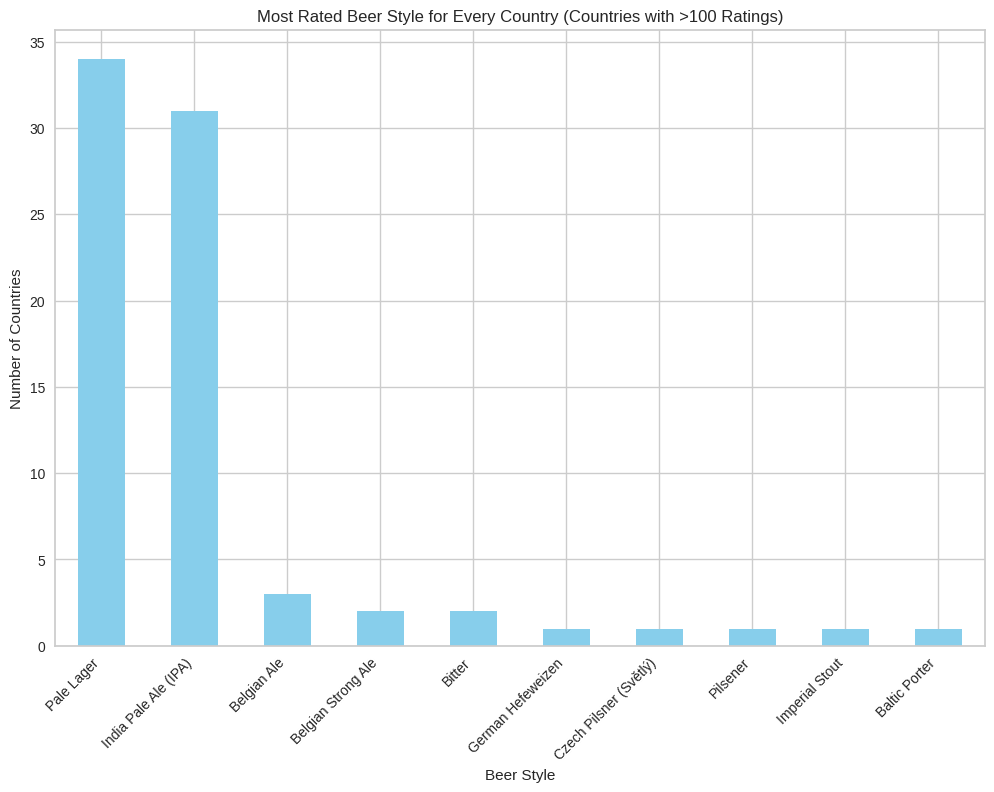

In [ ]:
# Step 1: Filter countries with more than 100 ratings
countries_over_100_ratings = df_merged['country'].value_counts()[df_merged['country'].value_counts() > 100].index
ratings_filtered = df_merged[df_merged['country'].isin(countries_over_100_ratings)]

# Step 2: Find the most rated beer style for each country
most_rated_per_country = ratings_filtered.groupby('country')['style'].apply(lambda x: x.value_counts().idxmax())

# Step 3: Create a histogram
plt.figure(figsize=(12, 8))

most_rated_per_country.value_counts().plot(kind='bar', color='skyblue')
plt.title('Most Rated Beer Style for Every Country (Countries with >100 Ratings)')
plt.xlabel('Beer Style')
plt.ylabel('Number of Countries')
plt.xticks(rotation=45, ha='right')
plt.show()

As expected the Pale Lager as well as the IPA are again the most commonly rated beer styles, with over 60 countries having one of those two as the most rated beer style.

We can see some beer styles that come from specific countries (Belgian Ale, German Hefeweizen, Czech Pilsner (Světlý)). Let's see if the coutries they are most popular are indeed the countries from which they come from.

In [ ]:
# Step 3: Find the countries where the most rated style is 'Czech Pilsner (Světlý)'
countries_most_rated_belgian_ale = most_rated_per_country[most_rated_per_country == 'Belgian Ale'].index
countries_most_rated_german_hefeweizen = most_rated_per_country[most_rated_per_country == 'German Hefeweizen'].index
countries_most_rated_czech_pilsner = most_rated_per_country[most_rated_per_country == 'Czech Pilsner (Světlý)'].index
# Display the result
print(f"The countries where the most rated beer style is 'Belgian Ale' are: {', '.join(countries_most_rated_belgian_ale)}")
print(f"The countries where the most rated beer style is 'German Hefeweizen' are: {', '.join(countries_most_rated_german_hefeweizen)}")
print(f"The countries where the most rated beer style is 'Czech Pilsner (Světlý)' are: {', '.join(countries_most_rated_czech_pilsner)}")

The countries where the most rated beer style is 'Belgian Ale' are: Belgium, Dominican Republic, Netherlands
The countries where the most rated beer style is 'German Hefeweizen' are: Andorra
The countries where the most rated beer style is 'Czech Pilsner (Světlý)' are: Czech Republic


Amazing! Indeed the Belgian Ale is the most rated beer in Belgium and the Netherlands (which is really close) but also interestingly in the Dominican Republic. Also interestingly the German Hefeweizen is the most popular in Andorra for reasons that are mysterious. Finally the Czech Pilsner (Světlý) is the most rated beer in the Czech republic.

Now that we have analyzed the beer styles depending on the number of their ratings we will focus on beer styles that have the best ratings. It will be interesting to see if the beer styles that are the most rated are also the ones who are the most appreciated. In particular we will check if the Belgian Ale and Czech Pilsner (Světlý) are the preferred beer in the two respective countries.

# Best rated beer styles


Now that we have found the most rated beer styles let's see if these correspond to the best rated beer styles as well or if they are different. We prform a similar analysis scenario as for the most rated beers.

In [ ]:
# Calculate mean rating and count of ratings for each style within each region
result = df_merged.groupby(['region', 'style']).agg({'rating': ['mean', 'count']}).reset_index()
result.columns = ['region', 'style', 'mean_rating', 'num_ratings']

# Find the three best-rated beer styles for each region based on mean rating
best_styles_by_region = result.groupby('region').apply(lambda x: x.nlargest(3, 'mean_rating')).reset_index(drop=True)

# Display the result
display(best_styles_by_region)

,region,style,mean_rating,num_ratings
0,Africa,Eisbock,4.066667,3
1,Africa,Abt/Quadrupel,3.917978,89
2,Africa,Sour Red/Brown,3.914815,27
3,Asia,Saké - Ginjo,3.825000,4
4,Asia,Imperial Stout,3.778426,5043
5,Asia,Lambic Style - Gueuze,3.771536,534
6,Europe,Imperial Stout,3.831068,134333
7,Europe,Abt/Quadrupel,3.774143,25045
8,Europe,Lambic Style - Gueuze,3.728160,16296
9,North America,Abt/Quadrupel,3.876762,36642


Let's first note that some of the best rated beers have very few ratings.
What we see is quite interesting. We can see that the IPA and the Pale Lager don't appear at all in the best rated beers. The beers that appear the most often as the best or second best are the Abt/Quadrupel best rated for South America, Oceania and North America and second for Africa (first excluding Eisbock with only 3 ratings) as well as for Europe. The other very enjoyed beer style is the Inperial Stout, best rated beer style in Europe and second on many continents. It is also interesting to note that Lambic beers (a type of beer brewed in the Pajottenland region of Belgium) seems to be quite enjoyed all over the world.

We can do the same thing for Europe and its subregions

In [ ]:
# Calculate mean rating and count of ratings for each style within each subregion
result = df_merged[df_merged['region'] == 'Europe'].groupby(['subregion', 'style']).agg({'rating': ['mean', 'count']}).reset_index()
result.columns = ['subregion', 'style', 'mean_rating', 'num_ratings']

# Find the three best-rated beer styles for each subregion based on mean rating
best_styles_by_subregion = result.groupby('subregion').apply(lambda x: x.nlargest(3, 'mean_rating')).reset_index(drop=True)

# Display the result
display(best_styles_by_subregion)

,subregion,style,mean_rating,num_ratings
0,Eastern Europe,Saké - Ginjo,3.900000,1
1,Eastern Europe,Abt/Quadrupel,3.888445,2077
2,Eastern Europe,Saké - Infused,3.850000,2
3,"Eastern Europe, The Middle East",Eisbock,4.125000,4
4,"Eastern Europe, The Middle East",Imperial Stout,4.048447,161
5,"Eastern Europe, The Middle East",Abt/Quadrupel,3.983871,31
6,Northern Europe,Imperial Stout,3.815536,84794
7,Northern Europe,Lambic Style - Gueuze,3.727436,9462
8,Northern Europe,Abt/Quadrupel,3.721110,12553
9,"Northern Europe, Sub-Saharan Africa",Abt/Quadrupel,4.400000,1


As expected the Abt/Quadrupel and Imperial Stout are the most liked beers.

To quantify all of this let's plot a histogram of the number of countries in the world and their preferred beer styles.

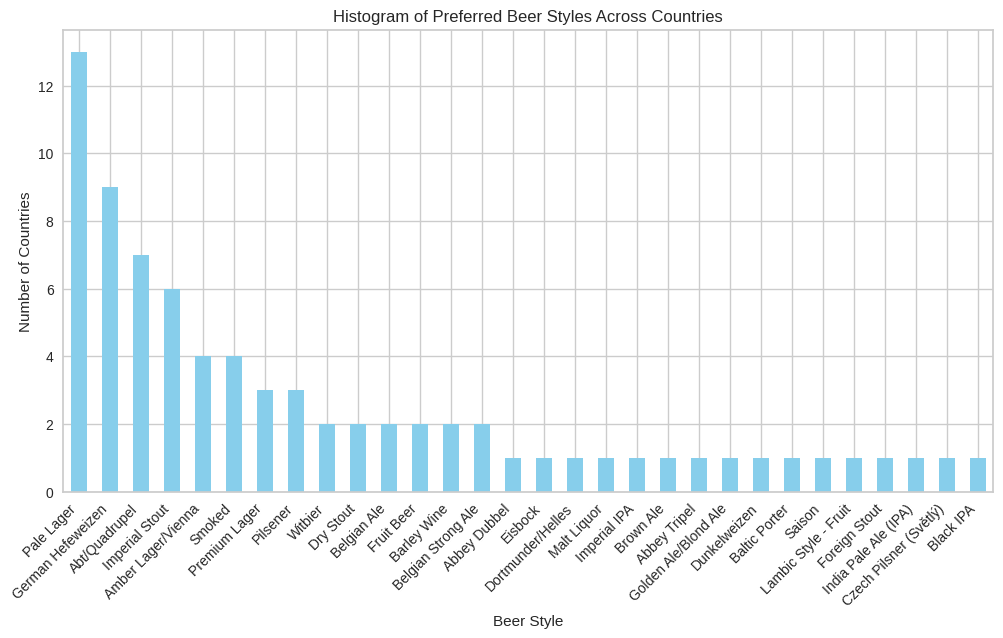

In [ ]:
# Step 1: Select countries with more than 100 ratings
countries_over_100_ratings = df_merged['country'].value_counts()[df_merged['country'].value_counts() > 100].index
df_filtered = df_merged[df_merged['country'].isin(countries_over_100_ratings)]

# Step 2: Find the best-rated beer for every country
best_beers = df_filtered.loc[df_filtered.groupby('country')['rating'].idxmax()]

# Step 3: Create a histogram of the number of countries whose preferred beer style is one of the styles
plt.figure(figsize=(12, 6))
best_beers['style'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Histogram of Preferred Beer Styles Across Countries')
plt.xlabel('Beer Style')
plt.ylabel('Number of Countries')
plt.xticks(rotation=45, ha='right')
plt.show()

We can clearly see that the beer style that is best rated in most countries is the Pale Lager. We then have the German Hefeizen, Abt/Quadrupel and Imperial Stout. These beer styles have more than 5 countries for which this is the favorite beer style. The other styles are less common. It is interesting to see that there are many countries who have one specific beer style that they like the most. One can check that this is not due to the fact that there's only 1 rating of this style by excluding beer styles that have less than 15 ratings and taking only countries above 150 ratings. This is done below

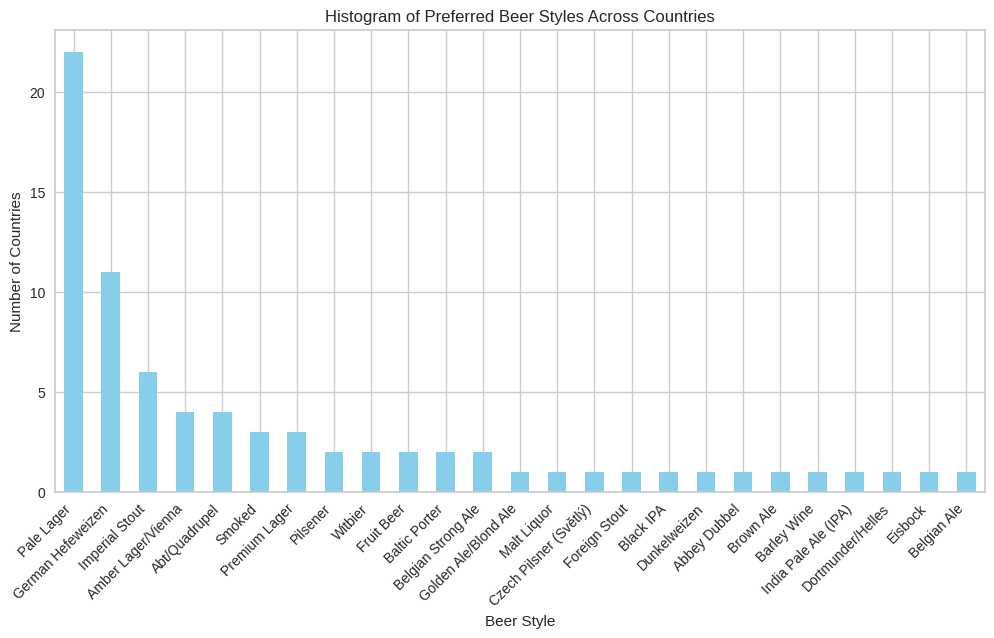

In [ ]:
# Step 1: Select countries with more than 100 ratings
countries_over_150_ratings = df_merged['country'].value_counts()[df_merged['country'].value_counts() > 150].index
df_filtered = df_merged[df_merged['country'].isin(countries_over_150_ratings)]

# Step 2: Find the best-rated beer for every country
best_beers = df_filtered.loc[df_filtered.groupby('country')['rating'].idxmax()]

# Step 3: Remove beer styles with fewer than 10 ratings for each country
df_filtered = df_filtered.groupby(['country', 'style']).filter(lambda x: x['rating'].count() >= 15)

# Step 4: Adjust the best beer styles based on the new condition
for country in best_beers['country'].unique():
    best_style = best_beers.loc[best_beers['country'] == country, 'style'].values[0]
    if df_filtered[(df_filtered['country'] == country) & (df_filtered['style'] == best_style)]['rating'].count() < 15:
        new_best_style = df_filtered[(df_filtered['country'] == country) & (df_filtered['rating'].count() >= 15)]['style'].iloc[0]
        best_beers.loc[best_beers['country'] == country, 'style'] = new_best_style

# Step 5: Create a histogram of the number of countries whose preferred beer style is one of the styles
plt.figure(figsize=(12, 6))
best_beers['style'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Histogram of Preferred Beer Styles Across Countries')
plt.xlabel('Beer Style')
plt.ylabel('Number of Countries')
plt.xticks(rotation=45, ha='right')
plt.show()

As can be seen there are still many countries that have a very specific preferred beer style. Let's take a close look at the Czech Pilsner (Světlý), is it the preferred style in the Czech republic or somewhere else.

In [ ]:
# Step 3: Find the country that has the preferred beer style "Czech Pilsner (Světlý)"
preferred_beer_style = 'Czech Pilsner (Světlý)'
preferred_country_stats = df_filtered[df_filtered['style'] == preferred_beer_style].groupby('country')['rating'].mean()
preferred_country = preferred_country_stats.idxmax()

# Step 4: Check the number of ratings for "Czech Pilsner (Světlý)" in the preferred country
preferred_style_stats = df_filtered[(df_filtered['country'] == preferred_country) & (df_filtered['style'] == preferred_beer_style)]
num_ratings = preferred_style_stats.shape[0]

# Display the result
print(f"The preferred beer style for {preferred_country} is {preferred_beer_style}.")
print(f"Number of ratings for {preferred_beer_style} in {preferred_country}: {num_ratings}")

The preferred beer style for Japan is Czech Pilsner (Světlý).
Number of ratings for Czech Pilsner (Světlý) in Japan: 250


That's surprising, it seems that Japan's most liked beer style is the Czech Pilsner (Světlý). Let's juste verify that this doesn't come from some user who particularly likes this type of beer or for example moved to the Czech Republic at some point. For this we first check how many users have rated beers in Japan. We then look at the number of ratings of the top users. Finally we look at how many users have rated the Czech Pilsner (Světlý).

In [ ]:
# Check the number of users from Japan
num_users_japan = df_users_loc[df_users_loc['location'] == 'Japan'].shape[0]

# Display the result
print(f"Number of users from Japan: {num_users_japan}")

Number of users from Japan: 118


In [ ]:
# Filter users from Japan
users_japan = df_users_loc[df_users_loc['location'] == 'Japan']

# Display the top 5 users from Japan with the most ratings
top_users_japan = users_japan.nlargest(5, 'nbr_ratings')
print(top_users_japan)

      nbr_ratings  user_id       user_name        joined location
900          8694    80641      KyotoLefty  1.216894e+09    Japan
330          5217     4953            TimE  1.025950e+09    Japan
994          4663   236410  KansaiBeerLvrs  1.357038e+09    Japan
1711         3878    61731  shoulderbroken  1.191233e+09    Japan
1789         3493    15070         maekchu  1.094465e+09    Japan


In [ ]:
# Filter ratings for Czech Pilsner (Světlý) in Japan
filtered_ratings = df_filtered[(df_filtered['style'] == 'Czech Pilsner (Světlý)') & (df_filtered['country'] == 'Japan')]

# Find the number of users who have rated Czech Pilsner (Světlý) in Japan
num_users_rated = filtered_ratings['user_id'].nunique()

# Display the result
print(f"Number of users who have rated Czech Pilsner (Světlý) in Japan: {num_users_rated}")

Number of users who have rated Czech Pilsner (Světlý) in Japan: 19


Having checked all this we can safely confirm that it's not a single user that biased the results. The Czech Pilsner (Světlý) really seems to be the beer style that is preferred in Japan. Maybe this is because a bunch of friends got together and went to the Czech Republic. A Japanese person wrote on Quora that the image of the Czech Republic is extremely good in Japan. While this is not necessarily a reliable source, the fact that Kyoto and Prague are sister cities and that the Czech ambassador to Japan presents the so called Friendship Trophy, a Bohemian Glass trophy, to the Sumo Champion every year since 1970, might contribute to this preference.

Finally we have found before that the Belgian Ale is the most popular beer style in Belgium and that the Czech Pilsner (Světlý) is the most rated beer style in the Czech Republic. Let's see if it also appears as one of the most liked beer styles.

In [ ]:

# Step 1: Filter ratings for Belgium and the Czech Republic
ratings_belgium = df_merged[df_merged['country'] == 'Belgium']
ratings_czech_republic = df_merged[df_merged['country'] == 'Czech Republic']

# Step 2: Find the best-rated beer styles for Belgium along with the number of ratings
best_rated_belgium = ratings_belgium.groupby('style').agg({'rating': ['mean', 'count']})
best_rated_belgium.columns = ['mean_rating', 'num_ratings']
best_rated_belgium = best_rated_belgium.nlargest(5, 'mean_rating')
print("Best-rated beer styles in Belgium:")
print(best_rated_belgium)

# Step 3: Find the best-rated beer styles for the Czech Republic along with the number of ratings
best_rated_czech_republic = ratings_czech_republic.groupby('style').agg({'rating': ['mean', 'count']})
best_rated_czech_republic.columns = ['mean_rating', 'num_ratings']
best_rated_czech_republic = best_rated_czech_republic.nlargest(5, 'mean_rating')
print("\nBest-rated beer styles in the Czech Republic:")
print(best_rated_czech_republic)

Best-rated beer styles in Belgium:
                       mean_rating  num_ratings
style                                          
Imperial Stout            3.888958         6457
Abt/Quadrupel             3.834362         2593
Lambic Style - Gueuze     3.777257         1728
Imperial IPA              3.774978         3361
American Strong Ale       3.766087          690

Best-rated beer styles in the Czech Republic:
                       mean_rating  num_ratings
style                                          
Saké - Ginjo              3.900000            1
Abt/Quadrupel             3.891489           94
Imperial Stout            3.855899          517
Lambic Style - Gueuze     3.813889           72
Imperial Porter           3.804054           74


Interesting! It's not even in the top 5 most liked beers for both styles. Let's find it!

In [ ]:
# Step 1: Filter ratings for all styles in Belgium
ratings_belgium = df_merged[df_merged['country'] == 'Belgium']

# Step 2: Calculate the average rating for each style in Belgium
average_ratings_by_style_belgium = ratings_belgium.groupby('style')['rating'].mean()

# Step 3: Find the average rating for Belgian Ale
average_rating_belgian_ale = average_ratings_by_style_belgium.get('Belgian Ale', None)

# Step 4: Calculate the rank of Belgian Ale among all styles
rank_among_all_styles_belgium = (average_ratings_by_style_belgium > average_rating_belgian_ale).sum() + 1

# Display the result
print(f"The average rating for Belgian Ale in Belgium is: {average_rating_belgian_ale:.2f}")
print(f"The rank of Belgian Ale among all styles in Belgium is: {int(rank_among_all_styles_belgium)}")

The average rating for Belgian Ale in Belgium is: 3.26
The rank of Belgian Ale among all styles in Belgium is: 50


In [ ]:
# Step 1: Filter ratings for all styles in the Czech Republic
ratings_czech_republic = df_merged[df_merged['country'] == 'Czech Republic']

# Step 2: Calculate the average rating for each style in the Czech Republic
average_ratings_by_style = ratings_czech_republic.groupby('style')['rating'].mean()

# Step 3: Find the average rating for Czech Pilsner (Světlý)
average_rating_czech_pilsner = average_ratings_by_style.get('Czech Pilsner (Světlý)', None)

# Step 4: Calculate the rank of Czech Pilsner (Světlý) among all styles
rank_among_all_styles = (average_ratings_by_style > average_rating_czech_pilsner).sum() + 1

# Display the result
print(f"The average rating for Czech Pilsner (Světlý) in the Czech Republic is: {average_rating_czech_pilsner:.2f}")
print(f"The rank of Czech Pilsner (Světlý) among all styles in the Czech Republic is: {int(rank_among_all_styles)}")

The average rating for Czech Pilsner (Světlý) in the Czech Republic is: 3.03
The rank of Czech Pilsner (Světlý) among all styles in the Czech Republic is: 60


Wow! The Belgian Ale is only the 50th most liked beer style in Belgium and the Czech Pilsner (Světlý) is 60th in the Czech Republic. This clearly shows that the most popular beers are not necessarily the most liked and also disproves (at least superficially) the hypothesis of "The beer tastes best in the country where it comes from", a popular saying for the Guinness which is said to taste best in Ireland.

##Appendix

This section is used to compute all the graph for the website

### Question 1

In [ ]:
df_rate_avg_style

fig_q1_1 = px.line(df_rate_avg_style, x="year", y="rating", color="style_group", title='Average rating through the years per beer type')
fig_q1_1.show()
fig_q1_1.write_html('fig_q1_1.html')

In [ ]:
df_rate_c_avg_pivot_plot = pd.melt(df_rate_c_avg_pivot.T.reset_index(drop=False), id_vars=['style_group'], value_vars=list(range(2000, 2018)))
fig_q1_2 = px.area(df_rate_c_avg_pivot_plot, x='year', y='value',
                   color='style_group', title='Amount of rating per group per year')

fig_q1_2.show()
fig_q1_2.write_html('fig_q1_2.html')

In [ ]:
fig_q1_3 = px.line(popular_beers_df_px, x='year', y='value', color='style',
                   title='Beer styles with highest growth through the years')
fig_q1_3.show()
fig_q1_3.write_html('fig_q1_3.html')

### Question 4


In [ ]:
# Create a histogram with Plotly Express
fig_q4_1 = px.histogram(x=average_ratings, nbins=10, opacity=0.7,
                   labels={'x': 'Average Rating', 'y': 'Number of regions'},
                   title='Distribution of Average Ratings for Top Regions with >1,000 Ratings')

# Calculate mean and std
mean_value = sum(average_ratings) / len(average_ratings)
std_value = (sum((x - mean_value) ** 2 for x in average_ratings) / len(average_ratings)) ** 0.5

fig_q4_1.update_layout(
    legend=dict(x=0, y=1, traceorder='normal', orientation='h', font=dict(size=12)),
    annotations=[
        dict(x=0.1, y=1, xref='paper', yref='paper', showarrow=False,
             text=f'Mean:', font=dict(size=14)),
        dict(x=0.2, y=1, xref='paper', yref='paper', showarrow=False,
             text=f'{mean_value:.2f}', font=dict(size=14)),
        dict(x=0.3, y=1, xref='paper', yref='paper', showarrow=False,
             text=f'Std:', font=dict(size=14)),
        dict(x=0.42, y=1, xref='paper', yref='paper', showarrow=False,
             text=f'{std_value:.2f}', font=dict(size=14))
    ]
)


# Customize the y-axis label
fig_q4_1.update_layout(yaxis_title='Count of Regions')
fig_q4_1.show()
# Save the figure as an HTML file

fig_q4_1.write_html('fig_q4_1.html')

In [ ]:
# Create a bar chart using Plotly Express
fig_q4_2 = px.bar(most_rated_per_country.value_counts(),
             x=most_rated_per_country.value_counts().index,
             y=most_rated_per_country.value_counts().values,
             color_discrete_sequence=['skyblue'],  # Set a constant color
             labels={'y': 'Number of Countries', 'x': 'Beer Style'},
             title='Most rated beer style for countries with >100 Ratings',
             template='plotly')

# Rotate x-axis labels for better readability
fig_q4_2.update_layout(xaxis_tickangle=-45)
fig_q4_2.show()

# Save the figure as an HTML file
fig_q4_2.write_html('fig_q4_2.html')

In [ ]:
# Create a bar chart using Plotly Express
fig_q4_3 = px.bar(best_beers['style'].value_counts(), x=best_beers['style'].value_counts().index, y=best_beers['style'].value_counts().values,
             color_discrete_sequence=['skyblue'],  # Set a constant color
             labels={'y': 'Number of Countries', 'x': 'Beer Style'},
             title='Histogram of Preferred Beer Styles Across Countries',
             template='plotly')

# Rotate x-axis labels for better readability
fig_q4_3.update_layout(xaxis_tickangle=-45)
fig_q4_3.show()

# Save the figure as an HTML file
fig_q4_3.write_html('fig_q4_3.html')